In [941]:
import nltk
import re, string
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk import ngrams
import operator
from gensim.models.word2vec import Word2Vec
import gensim
import pandas
import sklearn.manifold
from sklearn.manifold import TSNE
from bokeh.io import output_notebook
from bokeh.plotting import show, figure

In [942]:
#Read the dataset - First Set of Questions
path = '/Users/shelinakhan/Desktop/Web_Data/RAP_Data/'
filePrefix = 'Week1_Q'
dataset={}
dataset_raw = {}
allFeatures=set()
tot_articles = 0
articles_count={}
questions=[1,2,3,4]

N={} # Number of articles

for question in questions:
    fileName=path+filePrefix+str(question)+".txt"
    f=open(fileName,'r')
    text = ''
    text_raw = ''    
    lines=f.readlines()
    tot_articles+=len(lines)
    articles_count[str(question)] = len(lines)
    dataset_raw[str(question)] = list(map(lambda line: line.lower(), lines))
    
    for line in lines:
        text+=line.replace('\n',' ').lower()
        text_raw = line.lower()
    f.close
    N[str(question)]=len(lines)
    
    tokens = nltk.word_tokenize(text)
    dataset[str(question)] = nltk.Text(tokens)
    

In [943]:
dataset_clean= {}
min_freq = 3

def getCollocations(text, min_freq, coll_num):
    bigrams = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(text)
    finder.apply_freq_filter(min_freq)
    collocations = finder.nbest(bigrams.pmi, coll_num)
    return collocations

def remove_punctuation(corpus):
    punctuations = ".,\"-\\/#!?$%\^&\*;:{}=\-_'~()"    
    filtered_corpus = [token for token in corpus if (not token in punctuations)]
    return filtered_corpus

def apply_stopwording(corpus, min_len):
    filtered_corpus = [token for token in corpus if (not token in stopwords.words('english') and len(token)>min_len)]
    return filtered_corpus 

def apply_lemmatization(corpus):
    lemmatizer = nltk.WordNetLemmatizer()
    normalized_corpus = [lemmatizer.lemmatize(token) for token in corpus]
    return normalized_corpus

In [944]:
file_input = (dataset_raw[str(1)]) + (dataset_raw[str(2)]) + (dataset_raw[str(3)])+(dataset_raw[str(4)])

# Word Summary by Word Importance ###

In [945]:
def getSummary(article, low, high, num_of_sentences):
    freq={}
    sentences = sent_tokenize(article)
    # Calculate word frequencies
    for sentence in sentences:
        doc =nltk.Text(nltk.word_tokenize(sentence.lower()))
        doc_clean = apply_lemmatization(apply_stopwording(remove_punctuation(doc), 3))
        for token in doc_clean:
            if token in freq.keys():
                freq[token]+=1
            else:
                freq[token]=1
    
    #Normalize the counts: divide by the largest frequency so we can make comparisons
    max_freq = float(max(freq.values()))
    freq_final={}

    #Removing too frequenty (max_freq) or less frequent (min_frequent) elements
    for token in freq.keys():
        freq[token]=freq[token]/max_freq
        if (freq[token]<high and freq[token]>low):
            freq_final[token]=freq[token]
    
    
    scores = {}
    sLen = 0.0
    for sentence in sentences:
        doc =nltk.Text(nltk.word_tokenize(sentence.lower()))
        doc_clean = apply_lemmatization(apply_stopwording(remove_punctuation(doc), 3))
        
        if len(doc_clean)>sLen:
            sLen = len(doc_clean)
        
        for token in doc_clean:
            if (token in freq_final.keys()):
                if sentence in scores.keys():
                    scores[sentence]+=freq_final[token]
                else:
                    scores[sentence]=freq_final[token]
        
    for key in scores.keys():
        scores[key]=scores[key]/sLen

    sorted_sentences = reversed(sorted(scores.items(), key=operator.itemgetter(1)))
    
    count = 1
    result = []
    for s in sorted_sentences:
        if (count<= num_of_sentences):
            sentence = s[0]
            score = s[1]
            result.append(sentence)
            count+=1
    return result



# Summary for Week 1

In [946]:
first_sum = getSummary(str(file_input), .4,.9,5)
print(first_sum)

['i do think that the fda will raise the issue of missed prostate cancer again and while claus is correct in stating that we now routinely use active surveillance in low-risk men, one might postulate that the men with prostate cancer "causing" luts (cause in quotations because, lets face it, its pretty rare that cap causes luts although we like to make that connection) are more likely to have higher risk cancer.', 'this lack of association was consistent across subgroups defined by type of bph-defining event (treatment, symptoms, or physician diagnosis), prompt for prostate cancer diagnosis, and prostate cancer grade.', 'as noted in the warning section of the rx insert: " screening for prostate cancer prostate cancer and bph frequently co-exist; therefore, patients should be screened for the presence of prostate cancer prior to treatment with tamsulosin hydrochloride capsules and at regular intervals afterwards".', "one occurrence of a very rare event in the population more likely to h

# Summary of the Summary for Week 1

second_sum = getSummary(str(first_sum), .4, .9, 10)
(str(second_sum))

### Summary by Word Collocations ###

In [947]:
def getCollocations(text, min_freq):
    bigrams = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(text)
    finder.apply_freq_filter(min_freq)
    collocations = finder.nbest(bigrams.pmi, 20)
    return collocations

def getSummaryByColl(article, min_freq):
    sentences = sent_tokenize(article)
    #tokens = [word_tokenize(sentence.lower()) for sentence in sentences]
    tokens = nltk.word_tokenize(article.lower())
    doc = nltk.Text(tokens)
    doc_clean = nltk.Text(apply_lemmatization(apply_stopwording(remove_punctuation(doc), 3)))
    collocations = getCollocations(doc_clean,min_freq)

    summary = []
    for c in collocations:
        for sentence in sentences:
            term1 = c[0]
            term2 = c[1]
            term = c[0]+' '+c[1]
            if (term in sentence):
                #Found the sentence. Add only if not already in the summary
                if (sentence not in summary):
                    summary.append(sentence)
                
    return summary

# Summary of the entire Week 1 - by Collocations

In [948]:
# summary of the entire week 1 - by collocations
summary_by_coll = getSummaryByColl(str(file_input),2)
print(summary_by_coll)

['association of symptomatic benign prostatic hyperplasia and prostate cancer: results from the prostate cancer prevention trial.', 'this study examined the association between symptomatic benign prostatic hyperplasia (bph) and prostate cancer risk in 5,068 placebo-arm participants enrolled in the prostate cancer prevention trial (1993–2003).', 'bill soller\\n", \'inclusion criteria: 1. men, 18 years of age and older 2. able to speak, read and understand english.', "bill soller\\n', 'everyone was given an alias except the active co-chair.", 'i think fda will be concerned about those men who have a concomitant condition with bph/luts who obtain partial relief from tamsulosin hydrochloride, are comfortable enough with the improvement not to bother getting checked out, and don\'t discuss their symptoms with their physician.\\n", \'your point...."fda will be concerned about those men who have a concomitant condition with bph/luts who obtain partial relief from tamsulosin hydrochloride, are

# Word2Vec

In [949]:
sa_sentences = sent_tokenize(str(file_input))
tokens = []
for sentence in sa_sentences:
    t = word_tokenize(sentence)
    tokens.append(apply_lemmatization(apply_stopwording(remove_punctuation(t),3)))

In [950]:
print(len(sa_sentences))
print(sa_sentences[0:5])
print(len(tokens))
print(tokens[0:5])

232
["['no i dont think so - we did this with oab and patients seem to be able to make correct decisions and understand their co-existent issues.", "in other words i do think that they are appropriate the symptoms mentioned only can be confuse with underactive bladder which may have similar type symptoms\\n', 'detrusor underactivity is a difficult to diagnose and not as common condition.", 'in selected clinic and urodynamic series it may occur in 15% or so.', 'i agree that the symptoms may partially overlap, but even md provider will likely give alpha blocker to those pts as they do not have a full uds examination to review.\\n\', "it\'s not inappropriate for these patients to take tamsulosin.', 'the main issue is going to be whether or not the data are considered adequate to demonstrate that people who have not been diagnosed already with these comorbid conditions and take otc tamsulosin hydrochloride receive their diagnosis promptly.']
232
[['dont', 'think', 'patient', 'seem', 'able'

In [951]:
w2v_model = Word2Vec(sentences = tokens, size = 32, sg= 1, window = 5, min_count = 5, seed = 20, workers = 2)

In [952]:
print(len(w2v_model.wv.vocab))
print(w2v_model.wv.vocab)

128
{'think': <gensim.models.keyedvectors.Vocab object at 0x11f014a20>, 'patient': <gensim.models.keyedvectors.Vocab object at 0x11f0149e8>, 'able': <gensim.models.keyedvectors.Vocab object at 0x11f014978>, 'make': <gensim.models.keyedvectors.Vocab object at 0x11f014908>, 'understand': <gensim.models.keyedvectors.Vocab object at 0x11f014a90>, 'issue': <gensim.models.keyedvectors.Vocab object at 0x11f014198>, 'symptom': <gensim.models.keyedvectors.Vocab object at 0x11f014a58>, 'mentioned': <gensim.models.keyedvectors.Vocab object at 0x11f014240>, 'bladder': <gensim.models.keyedvectors.Vocab object at 0x11f014358>, 'type': <gensim.models.keyedvectors.Vocab object at 0x11f002cf8>, 'condition': <gensim.models.keyedvectors.Vocab object at 0x11f002f60>, 'agree': <gensim.models.keyedvectors.Vocab object at 0x11f002ac8>, 'even': <gensim.models.keyedvectors.Vocab object at 0x11f0029b0>, 'likely': <gensim.models.keyedvectors.Vocab object at 0x11f002160>, 'alpha': <gensim.models.keyedvectors.Voca

In [953]:
X_32D=w2v_model[w2v_model.wv.vocab]
# Transform the data and load up a Panda dataframe
tSNE = TSNE(n_components=2, n_iter=1000)
X_2D = tSNE.fit_transform(X_32D)
x2D_df = pandas.DataFrame(X_2D, columns=['x','y'])
x2D_df['word'] = w2v_model.wv.vocab.keys()
x2D_df

/Users/shelinakhan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


,x,y,word
0,-1.855817,-2.721384,think
1,0.113433,1.042761,patient
2,0.316003,7.237381,able
3,-1.866168,4.652966,make
4,-3.975418,-1.477216,understand
5,-1.009621,4.543295,issue
6,0.601199,2.226027,symptom
7,-1.253157,0.326945,mentioned
8,-2.341548,-1.202970,bladder
9,-4.332932,3.506221,type


In [954]:
plot = figure(plot_width=800, plot_height=800)
_ = plot.text(x=x2D_df.x, y=x2D_df.y, text=x2D_df.word)
show(plot) #this plot puts together words that are similar together.

In [955]:
print(w2v_model.most_similar(positive=['prostate']))

[('change', 0.4661417007446289), ('given', 0.41448166966438293), ('alpha', 0.40304940938949585), ('medically', 0.4028976559638977), ('using', 0.3724732995033264), ('could', 0.3606048822402954), ('rate', 0.34481364488601685), ('case', 0.3352554440498352), ('underlying', 0.33472657203674316), ('labeling', 0.3144141435623169)]


/Users/shelinakhan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


# LDA

In [956]:
def remove_utf(text):
    return re.sub(r'[^\x00-\x7f]',r' ',text)

entire_week_1 = []
file_input_ = str(file_input)
lines = file_input_.split('.')
for line in lines:
    entire_week_1.append(remove_utf(line.lower()))

corpus = []
text=""

for line in entire_week_1:
    tokens = nltk.word_tokenize(line)
    doc = nltk.Text(tokens)
    doc_clean = nltk.Text(apply_lemmatization(apply_stopwording(remove_punctuation(doc), 3)))
    corpus.append(doc_clean)
    text=text+line
    

def getCollocations(text, min_freq, coll_num):
    bigrams = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(text)
    finder.apply_freq_filter(min_freq)
    collocations = finder.nbest(bigrams.pmi, coll_num)
    return collocations

def replaceCollocationsInText(text,collocations):
    first = [t[0]for t in collocations]
    second = [t[1] for t in collocations]

    dtokens = []
    i = 0
    while i<=(len(text)-1):
        try:
            idx1 = first.index(text[i])
            if (text[i+1]==second[idx1]):
                dtokens.append(first[idx1]+"_"+second[idx1])
                i=i+1
        except:
            dtokens.append(text[i])
            pass
        i=i+1
    return dtokens
        
tokens = nltk.word_tokenize(text)
doc = nltk.Text(tokens)
doc_clean = nltk.Text(apply_lemmatization(apply_stopwording(remove_punctuation(doc), 3)))
collocations = getCollocations(doc_clean,min_freq,100)
collocations[0:10]
first = [t[0]for t in collocations]
second = [t[1] for t in collocations]
print(collocations[0:3])
print(first[0:3])
print(second[0:3])

[('standard', 'care'), ('compare', 'proposed'), ('typical', 'practice')]
['standard', 'compare', 'typical']
['care', 'proposed', 'practice']


In [957]:
docs = []
for doc in corpus:
    t = replaceCollocationsInText(doc,collocations)
    if (len(t)>0):
        docs.append(replaceCollocationsInText(doc,collocations))

print(docs)

[['dont', 'patient', 'seem', 'able', 'make', 'correct', 'decision', 'understand', 'co-existent', 'issue'], ['word', 'appropriate', 'symptom', 'mentioned', 'confuse', 'underactive', 'similar', 'type', 'symptoms\\n', "'detrusor", 'underactivity', 'difficult', 'diagnose', 'common', 'condition'], ['selected', 'clinic', 'urodynamic', 'series', 'occur'], ['agree', 'symptom', 'partially', 'overlap', 'even', 'provider', 'likely', 'give', 'alpha_blocker', 'full', 'examination', 'review'], ['inappropriate', 'patient', 'take_tamsulosin'], ['main', 'issue', 'going', 'whether', 'data', 'considered', 'adequate', 'demonstrate', 'people', 'diagnosed', 'already', 'comorbid', 'condition', 'take_tamsulosin', 'hydrochloride', 'receive', 'diagnosis', 'promptly'], ['data', 'adequate', 'show', 'drug', 'delay_diagnosis', 'long', 'enough', 'result', 'adverse', 'consequence', 'acceptable'], ['really', 'dont', 'think'], ['guess', 'issue', 'underlying', 'comorbidity', 'whether', 'individual', 'taking', 'medicatio

In [958]:
from gensim import corpora
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]
import gensim
k=3
iterations = 20
topic_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word = dictionary, passes = iterations)

topics= topic_model.print_topics(num_words = 5)
print(topics) # what exactly is this telling me -- look at notes again.

[(0, '0.013*"data" + 0.012*"condition" + 0.009*"physician" + 0.008*"study" + 0.007*"diagnosis"'), (1, '0.011*"trial" + 0.009*"prostate_cancer" + 0.008*"condition" + 0.007*"data" + 0.007*"label"'), (2, '0.015*"risk" + 0.013*"study" + 0.009*"drug" + 0.007*"condition" + 0.007*"product"')]


In [959]:
import pyLDAvis.gensim
lda_vis = pyLDAvis.gensim.prepare(topic_model,corpus,dictionary,sort_topics=False)
lda_output = pyLDAvis.display(lda_vis)
lda_output

# Sentiment - Using Textblob

In [960]:
from textblob import TextBlob

In [961]:
# Need to get the POLARITY score of each sentence, and get the tally of Pos/Neg

def get_sent(text):
    Pos = []
    Neg = []
    Neu = []
    sentences = sent_tokenize(text)
    for sentence in sentences:
        txtblob = TextBlob(sentence)
        polaritys = (txtblob.sentiment.polarity)
        polaritys = [float(polaritys)]
        for i in polaritys:
            if i > 0:
                Pos.append(i)
            if i < 0:
                Neg.append(i)
            if i == 0:
                Neu.append(i)
    print("# of sentences: " +str(len(sentences)))
    print("Positive Tally:")
    print (len(Pos))
    print('Negative Tally: ') 
    print(len(Neg))
    print("Neutral Tally:") 
    print(len(Neu))
       
        
cluster1_ = "i guess the issue is not the underlying comorbidity but whether the individual is taking medications for certain conditions that might interact with the alpha blocker specifically, if they are on certain anti-hypertensive meds which might increase the risk of orthostasis. seems like a small number of meds and patients but something the fda might raise what diagnosis specifically do you think might be delayed. that is an issue difficult to resolve., we might be able to avoid some long-term misuse by encouraging a medical evaluation after 3 months of use. if our concern is the as-yet-undiscovered diagnosis, this is a risk with just about all otcs which could delay an actual pathologic diagnosis that might be useful to know. this  this is a lot for a package insert but it might need to be done.for the organizer, it would be good at this stage to have a proposed argument for why no trial period in the us, and an unbiased discussion of the group of what conditions, if any, would be appropriate for a trial run (which might be handled by exclusionary labeling perhaps some abbreviated use of a risk/benefit ratio might be helpful in the insert. it might work in the uk where the pharmacist is the: gate keeper, but in the us the product would be available on the shelf without the need for a learned intermediary. this population likely might have co-morbidities as your research has suggested but the frequency of same should not factor against this. i do think that the fda will raise the issue of missed prostate cancer again and while claus is correct in stating that we now routinely use active surveillance in low-risk men, one might postulate that the men with prostate cancer causing luts (cause in quotations because, lets face it, its pretty rare that cap causes luts although we like to make that connection) are more likely to have higher risk cancer. i know that men will do what they choose, but if we recommend seeing a physician if the otc is being used for more than a specific amount of time or if the urinary condition is not improved, we might get more men in to see the physician. another way to encourage physician visits is to note a few symptoms/signs that might indicate something more serious and recommend a medical appointment. that being said, my experience with the agency has been that they often tend to be overly cautious- particularly in quality of life conditions. even though its just one case of bladder cancer, one wonders if perhaps the ad com might end up saying its one too many- particularly if they are lead that way by the fda officials (which i have also seen) i think the way to handle is to underscore that most of the things that might be missed are not going to be medically significant. many of the prostate cancer cases that might be are going to be indolent. a single case of low-grade bladder cancer missed is not a big deal. this might be approachable by advising men who are using the otc product successfully for more than 3 months should see a physician. perhaps an algorithm of questions that include family history risk factors, symptoms and signs might work better to identify these other conditions of concern. in response to daenerys targaryens comment about studying whether consumers can use a urine dipstick correctly it might be informative to know that in the tamsulosin otc program urine samples were analyzed initially by the pharmacy staff but then using a dipstick reader my comment is just to help think about what might come up if fda or the ac members disagree. your response is exactly what we were hoping to get as the goal of this virtual advisory board is just that: to think about what might come up if fda or the ac members disagree with the company position. again, as with some of my other comments, the open discussion on this should determine if there is any subtype of potential users of alphabs which might actually benefit from a dipstick test, and if so, then determine then how this might be handled in labeling (i.e., special precaution to some users, or contraindication to some users). the postmarketing experience data might be more in line with what one could expect in an otc environment than the experience in the rcts. however in an otc setting if the profile seen in otc vs rx setting is changing one would need to understand what is driving the fatal cv event. so it is not an absolute number but rather an event by event investigation especially if it is something that is being driven by an underlying disease or in a consumer who over-rode the label to select and use the product. one occurrence of a very rare event in the population more likely to have the event in the eneral population may more likely be viewed as unrelated to the treatment (depending on the moa of the treatment), but two less so, and in any case any deaths in a trial needs individual investigation, contextualized by the inclusion and exclusion criteria for the trial echoing the other comments, the risk is low in that sample for that duration that an event will occur which cannot be readily explained by actual circumstances of the subjects health history and the event itself. bladder cancer is a disease of the elderly as well and thus both occur together frequently. normal bp or htn, dm or not, all normal healthy with no risk factors for heart disease, previous mi or not, etc. what is the distribution of underlying disease. there are many causes of cardiovascular events (arrhythmias, cardiomyopathy, certain types of cancer, drug therapy used to treat certain types of cancer, carotid and coronary artery disease. so it is not an absolute number but rather an event by event investigation especially if it is something that is being driven by an underlying disease or in a consumer who over-rode the label to select and use the product. further we do not know what consumer/pts where enrolled in the study, how many had cv disease at base lien so it really is a benefit vs risk assessment and absolute numbers dont always come into play.  i will try to address the last items here: clearly, many pts present with frequency, and nocturia when they are on antihypertensives specifically diuretics, they just dont put 2 and 2 together in that way. i have found many pts in the actual use study being on diuretics and having frequency. and actually in the actual use studies many pts state that they plan to bring it up with their doctor. in placebo control studies of men with bph / luts it may be as high a 2-5% it is interesting to note that one comorbid condition, prostate cancer, was mentioned as a caveat by the fda, but many of those pts we actually do not treat or discourage even the pursuit of a diagnosis. the potential types of consumers is vast as many men reported not seeing a hcp for their diagnosed pathology or not being compliant with the management regimen. the data generated in the studies that included a urine dipstick at baseline will be pooled to understand how many men followed up on this advice and if they didnt what their rationale was not to seek advice. there are many causes of cardiovascular events (arrhythmias, cardiomyopathy, certain types of cancer, drug therapy used to treat certain types of cancer, carotid and coronary artery disease. how many had cv disease at base lien so it really is a benefit vs risk assessment and absolute numbers dont always come into play. how much of that really did happen in how many pts, ie n/n is what we need here. in other words i do think that they are appropriate the symptoms mentioned only can be confuse with underactive bladder which may have similar type symptoms, detrusor underactivity is a difficult to diagnose and not as common condition. from the wording of your question, i am assuming these are patients who are already dx with the condition. but is could also be extended to patients who have not been dx yet and trying to treat a symptom thus a concern, whether real or hypothetical, would be to prove that the underlying condition would not produce one of the symptoms you are trying to treat. also if a patient is being treated with a rx drug, could one of the side effects be one of the urinary tract condition listed above that the patient now tries to treat on their own with the otc product. also, patients who use tamsulosin otc over the counter can be encouraged to talk with their physician at some point to clarify their condition and see if some additional treatment is needed. in placebo control studies of men with bph / luts it may be as high a 2-5% it is interesting to note that one comorbid condition, prostate cancer, was mentioned as a caveat by the fda, but many of those pts we actually do not treat or discourage even the pursuit of a diagnosis. while the likelihood of an diagnosed condition may be low it is not zero and it is this issue that fda will raise to the advisory committee. i know that men will do what they choose, but if we recommend seeing a physician if the otc is being used for more than a specific amount of time or if the urinary condition is not improved, we might get more men in to see the physician. its a certainty that the issue of the potential risk of an undiagnosed condition will be raised. the company team has not approached the issue from that angle as there is no agreed upon definition of what constitutes a condition of importance and the agencys concern is not only linked to undiagnosed conditions but also exacerbations of or suboptimally treated or even untreated known pathology. i think fda will be concerned about those men who have a concomitant condition with bph/luts who obtain partial relief from tamsulosin hydrochloride, are comfortable enough with the improvement not to bother getting checked out, and dont discuss their symptoms with their physician. therefore, patients should be screened for the presence of prostate cancer prior to treatment with tamsulosin hydrochloride capsules and at regular intervals afterwards. question is how will you handle this as the otc label will not capture this condition of use for physicians. most - but perhaps not the agency - believe the dipstick is an unnecessary complication in this process with limited yield of what is called a medically relevant condition, i see little value in enclosing a dipstick. this group is not in favor and does not see a benefit in it, this appears to be the case but i think that it will be important to craft a cogent argument that will convince the fda and the non-urologists on the advisory committee of the same. that argument, i think, rests in demonstrating that the delay of diagnosis of an underlying serious medical condition is not of clinical significance however if it is occurring in consumers at ow risk and the drug is causing this it could be problem especially since the drug would be taken for chronic use and is being used to treat a lifestyle condition.  no i dont think so - we did this with oab and patients seem to be able to make correct decisions and understand their co-existent issues. the main issue is going to be whether or not the data are considered adequate to demonstrate that people who have not been diagnosed already with these comorbid conditions and take otc tamsulosin hydrochloride receive their diagnosis promptly. i guess the issue is not the underlying comorbidity but whether the individual is taking medications for certain conditions that might interact with the alpha blocker that is an issue dificult to resolve. issue will be to show what the potential consumer would do and back it with data. in reply to claus re pcp and uro prescribing of alphabs for luts/bph, an important issue is how the otc labelig matches up with the current standard of care provided by pcps and uros. the big issue is what happens with these undiagnosed men. i do think that the fda will raise the issue of missed prostate cancer again and while claus is correct in stating that we now routinely use active surveillance in low-risk men, one might postulate that the men with prostate cancer causing luts (cause in quotations because, lets face it, its pretty rare that cap causes luts although we like to make that connection) are more likely to have higher risk cancer. i personally think that this is probably not the case but i could see the fda raising this issue. while the likelihood of an diagnosed condition may be low it is not zero and it is this issue that fda will raise to the advisory committee. hard to win over physicians on the panel by saying the risk is acceptable: so it becomes a political issue even though it may have started as a medical issue, especially since the main issue has been missed prostate cancer. so from a pure regulatory point of view, while the risk may be low, the issue is not if it is acceptable it is what are the consequences of a misdiagnosis for the consumer. i really do not see how this issue can be raised by the fda in the current climate. diabetes and utis were an issue of discussion for oxytrol because there were concerns that delaying the diagnosis can lead to significant systemic illness fairly rapidly. the issue raised is the carcinoma in situ example) i would say that concern is low on my radar. its a certainty that the issue of the potential risk of an undiagnosed condition will be raised. the company team has not approached the issue from that angle as there is no agreed upon definition of what constitutes a condition of importance and the agency\s concern is not only linked to undiagnosed conditions but also exacerbations of or suboptimally treated or even untreated known pathology. thank you for helping us think these issues through. when the details of the analysis are known, if the conclusion is an increase in fatal cv events of any magnitude that cannot be explained by data collection issues will be a problem do you have other information that is more specific to the issue.  some of us on the team remember when the otc review actually used physician experience by testimony as valid support for otcness and labeling, but as we know this is a much more data-driven process. that being said, my experience with the agency has been that they often tend to be overly cautious- particularly in quality of life conditions. as aspect of this is that one cannot discount the tails of the distribution, but rather address it head on with facts, clinical experience defined by standards of care, and best of all data. our experience is that this allows for a more robust/uninhibited conversation. the postmarketing experience data might be more in line with what one could expect in an otc environment than the experience in the rcts. can anyone speak more about what is known about the symptoms of bladder cancer becoming more obvious once luts/bph symptoms are relieved in a man with both of these conditions. bladder cancer diagnosis delay may be a big concern for the adcom and for the fda. do we have any idea how frequently bladder cancer and luts/bph are present concomitantly? bladder cancer is a disease of the elderly as well and thus both occur together frequently. . the actual diagnoses of bladder cancer was very low in the first study where all pts had full evaluation by a urologist. bladder cancer detection is most the time based on hematuria, rarely due to urgency and frequency (that is often stated in textbooks but rarely happens in real life. of the 729 men who were referred for a urologic assessment in study 527.83, one subject had an undiagnosed bladder cancer. even though its just one case of bladder cancer, one wonders if perhaps the ad com might end up saying its one too many- particularly if they are lead that way by the fda officials (which i have also seen). a single case of low-grade bladder cancer missed is not a big deal. i dont know the exact number but i would expect it to be the same as the untreated male population as mentioned by one of the other respondents), i would like to know the death rate in the clinical trials and how that compares with what you are seeing in your actual use study. as the drug has been approved and marketed for a number of years you have a baseline to use as a comparison. so it is not an absolute number but rather an event by event investigation especially if it is something that is being driven by an underlying disease or in a consumer who over-rode the label to select and use the product.  in summary it is not just a number but understanding the reason for the events. seems like a small number of meds and patients but something the fda might raise. one problem is that few pts do that despite me giving them my cell phone number. that will be the perspective of a number of adv. and actually in the actual use studies many pts state that they plan to bring it up with their doctor. some of us on the team remember when the otc review actually used physician experience by testimony as valid support for otcness and labeling, but as we know this is a much more data-driven process. in placebo control studies of men with bph / luts it may be as high a 2-5% it is interesting to note that one comorbid condition, prostate cancer, was mentioned as a caveat by the fda, but many of those pts we actually do not treat or discourage even the pursuit of a diagnosis. i have to leave it to annelie or wade to actually infuse these data into the discussion. failing to get improvement of the symptoms of bph may actually serve to scare men in to making an appointment. as with the previous question, it is really important to survey and characterize what men who develop these symptoms are actually doing about it. or can it be demonstrated that some will actually consult a physician? if the ac and the fda get stuck on dipsticks, though, what is missing is the ability to see that consumers can actually dip the stick and see the color changes for blood, glucose, etc, read those changes and then understand what the changes mean. again, as with some of my other comments, the open discussion on this should determine if there is any subtype of potential users of alphabs which might actually benefit from a dipsick test, and if so, then determine then how this might be handled in labeling. "
cluster2 = "i have found many pts in the actual use study being on diuretics and having frequency. it would seem from the data collected in the exploratory actual use study that men do mimic the trial run if you like as 36.7% only purchased 1 box of study drug and never returned to the participating pharmacy to repurchase product.it would seem from the data collected in the exploratory actual use study that men do mimic the trial run if you like as 36.7% only purchased 1 box of study drug and never returned to the participating pharmacy to repurchase product.do you have any info about why men did not but a second box in the exploratory actual use study .the actual diagnoses of bladder cancer was very low in the first study where all pts had full evaluation by a urologist. of the 729 men who were referred for a urologic assessment in study 527.83, one subject had an undiagnosed bladder cancer. this cancer was not causing or contributing to the urinary symptoms according to the study urologist. this specific individual reported that he saw his hcp on a very regular basis and had in fact see him/her within the month prior to study participation. list of msd, relevance of study rates to general population rates, importance of including people with known msd. this study examined the association between symptomatic benign prostatic hyperplasia (bph) and prostate cancer risk in 5,068 placebo-arm participants enrolled in the prostate cancer prevention trial (1993–2003).analyses were completed by bph status at baseline (prevalent) or bph prior to cancer diagnosis or study end (prevalent plus incident). this study provides the strongest evidence to date that bph does not increase the risk of prostate cancer.in the final actual use study the urine dipstick was repeated at end-of-study if it was abnormal at baseline and data on why men choose not to speak to their doctor even after a repeat dipstick finding will be analyzed. in the study it appears that men were told that an abnormality was there and to see a doctor but were not asked to interpret the dipstick findings on their own. best to gives us a specific objective of the study, and some inclusion/exclusion criteria, along the line of my questions below. what were the inclusion and exclusion criteria for the study. i would like to know the death rate in the clinical trials and how that compares with what you are seeing in your actual use study.  i would also want to know the cause of each death and whether the death could be attributed to study drug or somehow to the use of the drug in the otc environment. further we do not know what consumer/pts where enrolled in the study, how many had cv disease at base lien so it really is a benefit vs risk assessment and absolute numbers dont always come into play. not that long ago we did a headache study on and nce which had mild antiplatelet properties, and a young female study participant had a hemorrhagic stroke in the study. and a young female study participant had a hemorrhagic stroke in the study. thus the rct study populations do not resemble an allcomers otc-simulated study population. thus the rct study populations do not resemble an allcomers otc-simulated study population. in other words i do think that they are appropriate the symptoms mentioned only can be confuse with underactive bladder which may have similar type symptoms, detrusor underactivity is a difficult to diagnose and not as common condition. from the wording of your question, i am assuming these are patients who are already dx with the condition. but is could also be extended to patients who have not been dx yet and trying to treat a symptom thus a concern, whether real or hypothetical, would be to prove that the underlying condition would not produce one of the symptoms you are trying to treat. also if a patient is being treated with a rx drug, could one of the side effects be one of the urinary tract condition listed above that the patient now tries to treat on their own with the otc product. also, patients who use tamsulosin otc over the counter can be encouraged to talk with their physician at some point to clarify their condition and see if some additional treatment is needed. in placebo control studies of men with bph / luts it may be as high a 2-5% it is interesting to note that one comorbid condition, prostate cancer, was mentioned as a caveat by the fda, but many of those pts we actually do not treat or discourage even the pursuit of a diagnosis. while the likelihood of an diagnosed condition may be low it is not zero and it is this issue that fda will raise to the advisory committee. i know that men will do what they choose, but if we recommend seeing a physician if the otc is being used for more than a specific amount of time or if the urinary condition is not improved, we might get more men in to see the physician. its a certainty that the issue of the potential risk of an undiagnosed condition will be raised. the company team has not approached the issue from that angle as there is no agreed upon definition of what constitutes a condition of importance and the agencys concern is not only linked to undiagnosed conditions but also exacerbations of or suboptimally treated or even untreated known pathology. i think fda will be concerned about those men who have a concomitant condition with bph/luts who obtain partial relief from tamsulosin hydrochloride, are comfortable enough with the improvement not to bother getting checked out, and dont discuss their symptoms with their physician. therefore, patients should be screened for the presence of prostate cancer prior to treatment with tamsulosin hydrochloride capsules and at regular intervals afterwards. question is how will you handle this as the otc label will not capture this condition of use for physicians. most - but perhaps not the agency - believe the dipstick is an unnecessary complication in this process with limited yield of what is called a medically relevant condition, i see little value in enclosing a dipstick. this group is not in favor and does not see a benefit in it, this appears to be the case but i think that it will be important to craft a cogent argument that will convince the fda and the non-urologists on the advisory committee of the same. that argument, i think, rests in demonstrating that the delay of diagnosis of an underlying serious medical condition is not of clinical significance. however if it is occurring in consumers at ow risk and the drug is causing this it could be problem especially since the drug would be taken for chronic use and is being used to treat a lifestyle condition. the main issue is going to be whether or not the data are considered adequate to demonstrate that people who have not been diagnosed already with these comorbid conditions and take otc tamsulosin hydrochloride receive their diagnosis promptly. if the data are adequate to show that the otc drug does not delay the diagnosis long enough to result in adverse consequences then this should be acceptable. issue will be to show what the potential consumer would do and back it with data. do you have data regarding how internists or family practice physicians prescribe tamsulosin. it would seem from the data collected in the exploratory actual use study that men do mimic the trial run if you like as 36.7% only purchased 1 box of study drug and never returned to the participating pharmacy to repurchase product. the more that can be done to have data to demonstrate patient demographics, refill rates (and non-refill rates), reasons for decisions to continue or to stop, to seek a md visit or not, etc. the better for the argument. some of us on the team remember when the otc review actually used physician experience by testimony as valid support for otcness and labeling, but as we know this is a much more data-driven process. the complement is, do the data demonstrate that the physician selection of men suitable for alphabs is reasonably comparable to self-selection, wherein through this answer the label is shown adequate. the biggest risk is urinary retention which we know from the 5 alpha reductase data occurs in a small per cent on an annual basis- but results in little real morbidity wade can perhaps provide actual data. what specific data do you have to support your viewpoint. as aspect of this is that one cannot discount the tails of the distribution, but rather address it head on with facts, clinical experience defined by standards of care, and best of all data. i reiterate my call for an infusion of data into this blog. there are data from the early studies in which all men with any findings underwent full evaluation by a urologist. these data suggest a fairly low incidence of medically significant diseases.  i have to leave it to annelie or wade to actually infuse these data into the discussion. we dont know from current data as a unknown (i suspect very large) bias exists. these data include 1,225 men whose cancer was detected during the 7-year trial—556 detected for cause (following abnormal prostate-specific antigen or digital rectal examination) and 669 detected not for cause (without indication), as well as 3,843 men who had biopsy-proven absence of prostate cancer at the trial end. the data generated in the studies that included a urine dipstick at baseline will be pooled to understand how many men followed up on this advice and if they didnt what their rationale was not to seek advice. in the final actual use study the urine dipstick was repeated at end-of-study if it was abnormal at baseline and data on why men choose not to speak to their doctor even after a repeat dipstick finding will be analyzed. it appears that you dont plan to use a dipstick anyway because company feels the data werent suggestive that it was not needed. im okay with this, but would like to know the specific data (preferably publications) that support this, and what the standards of care used by pcps and uros states on this subject. in the absence of data that demonstrates the the dipstick is necessary to properly use the product, the inclusion adds an unnecessary layer of complexity to using the product correctly, lets put question # 3 to rest. i have to ask again for wade to perhaps provide some data. when the details of the analysis are known, if the conclusion is an increase in fatal cv events of any magnitude that cannot be explained by data collection issues will be a problem. the postmarketing experience data might be more in line with what one could expect in an otc environment than the experience in the rcts. an internal evaluation of the safety data relating to cardiovascular events and tamsulosin was performed and the results do not support a causal relationship. as part of the nda submission a full analysis will be performed on all available pharmacovigilance databases (external and internal) to assess this relationship further. i agree that the cdc data are not helpful. is there data available to this effect. i feel that the members of the adboard have a difficult time making statements in what essentially is a data vacuum. i feel that the members of the adboard have a difficult time making statements in what essentially is a data vacuum?!, yes, data helps drive conclusions and sort through opinions.  issue will be to show what the potential consumer would do and back it with data. i would eliminate as this is one more thing that will be a speed bump the consumer will have to get right to use the product correctly. the labeling should be adequate to drive the consumer to the physician if necessary. so it is not an absolute number but rather an event by event investigation especially if it is something that is being driven by an underlying disease or in a consumer who over-rode the label to select and use the product. specifically, if they are on certain anti-hypertensive meds which might increase the risk of orthostasis. if our concern is the as-yet-undiscovered diagnosis, this is a risk with just about all otcs which could delay an actual pathologic diagnosis that might be useful to know. this is a known risk of otcs. how do you think the populations in a typical practice compare with the proposed otc population with regard to risk. perhaps some abbreviated use of a risk/benefit ratio might be helpful in the insert. but to get the man to think like a doctor may require some unique way of designing an algorithm and/or noting risk/benefit considerations rather than simply displaying a list of information. a couple of comments ago, daenerys stated how do you think the populations in a typical practice compare with the proposed otc population with regard to risk. but how do studies convincingly demonstrate that populations in a typical practice compare with the proposed otc population with regard to risk. these may or may not be accurate. there is always a risk that consumers will use otc for misinterpreted reasons all that can be done is to try to put the indications, and the algorithm to help men decide whether or not this medicine is right for them, in as clear language as possible. so the incremental risk of trying tamsulosin hydrochloride would be low, as long as there are no contraindications. the biggest risk is urinary retention which we know from the 5 alpha reductase data occurs in a small per cent on an annual basis- but results in little real morbidity, indeed, aur has an incidence of 1% or 1 out of 100 men per year in population based studies. the likelihood of undiagnosed medically significant conditions is there. can you address the risk on a population basis. i do think that the fda will raise the issue of missed prostate cancer again and while claus is correct in stating that we now routinely use active surveillance in low-risk men. its pretty rare that cap causes luts although we like to make that connection) are more likely to have higher risk cancer. hard to win over physicians on the panel by saying the risk is acceptable: so it becomes a political issue even though it may have started as a medical issue, especially since the main issue has been missed prostate cancer. so from a pure regulatory point of view, while the risk may be low,the issue is not if it is acceptable it is what are the consequences of a misdiagnosis for the consumer. perhaps the otc algorithm needs to be clear about other potential risks and encourage men to visit a physician for regular check-up. its a certainty that the issue of the potential risk of an undiagnosed condition will be raised. i think a more systematic approach should be taken to answering this, and would like to suggest to the organizer/company to present into the discussion an safety algorithm that depicts types of consumers by diagnosed and undiagnosed conditions of importance, including the type of information/studies that mitigate concern with that putative risk. we dont know from current data as a unknown (i suspect very large) bias exists. heretofore as such patients are weaned out prior to evaluation, it seems to me that the risk to individuals with significant conditions that have not been diagnosed is not great with a 2 to 4 week trial of the product. this study examined the association between symptomatic benign prostatic hyperplasia (bph) and prostate cancer risk in 5,068 placebo-arm participants enrolled in the prostate cancer prevention trial (1993–2003). this study provides the strongest evidence to date that bph does not increase the risk of prostate cancer. it would detect very few of the co-morbid conditions of concern. perhaps an algorithm of questions that include family history risk factors, symptoms and signs might work better to identify these other conditions of concern. normal bp or htn, dm or not, all normal healthy with no risk factors for heart disease, previous mi or not, etc. however if it is occurring in consumers at ow risk and the drug is causing this it could be problem especially since the drug would be taken for chronic use and is being used to treat a lifestyle condition. further we do not know what consumer/pts where enrolled in the study, how many had cv disease at base lien so it really is a benefit vs risk assessment and absolute numbers dont always come into play. echoing the other comments, the risk is low in that sample for that duration that an event will occur which cannot be readily explained by actual circumstances of the subjects health history and the event itself. as is often the case, the sponsor has to accept a small risk that a serious ae occurs which is possibly drug related and cannot be readily explained. no we did not, i do not believe an otc product currently available uses the word \trial\ or \trial run\ on the label. this would seem somewhat unorthodox as well. what is on the label is the instruction to see your doctor if you have no improvement or worsening or such language. the label is the surrogate for the clinician. if an drug-drug interaction or a specific contraindication is needed for the product to be approved otc, the caution must be on the label and understood by the consumer. yes, otcness is predicated on the label, suitable evidence of label comprehension, and to the extent that the aus provides evidence of how self-selecting consumers behave in the context of the label, and the drug being studies in the aus. the complement is, do the data demonstrate that the physician selection of men suitable for alphabs is reasonably comparable to self-selection, wherein through this answer the label is shown adequate. plus the label and insert should be demonstrated to drive increased physician interactions. we can debate what the incidence is of undiagnosed conditions but key will be is you are suggesting that the otc label and conditions of use will be different than the rx label. we can debate what the incidence is of undiagnosed conditions but key will be is you are suggesting that the otc label and conditions of use will be different than the rx label. question is how will you handle this as the otc label will not capture this condition of use for physicians. (just thoughts for consideration-are you suggesting that the rx label will be changes or different than the otc label). so it is not an absolute number but rather an event by event investigation especially if it is something that is being driven by an underlying disease or in a consumer who over-rode the label to select and use the product. patients who use tamsulosin otc over the counter can be encouraged to talk with their physician at some point to clarify their condition and see if some additional treatment is needed. this would encourage men to go to physician for check-up. some of us on the team remember when the otc review actually used physician experience by testimony as valid support for otcness and labeling, but as we know this is a much more data-driven process. do the data demonstrate that the physician selection of men suitable for alphabs is reasonably comparable to self-selection. plus the label and insert should be demonstrated to drive increased physician interactions is there a way that an otc can be available but it does not significantly delay seeing a physician. but if we recommend seeing a physician if the otc is being used for more than a specific amount of time or if the urinary condition is not improved. we might get more men in to see the physician. perhaps the otc algorithm needs to be clear about other potential risks and encourage men to visit a physician for regular check-up.  another way to encourage physician visits is to note a few symptoms/signs that might indicate something more serious and recommend a medical appointment. i think that if you can show that there is a substantial lag time between symptom onset and seeking physician input for luts conditions other than bph then you can easily make the argument that a 2-week use of otc tamsulosin hydrochloride wont be clinically meaningful in that context. are comfortable enough with the improvement not to bother getting checked out, and dont discuss their symptoms with their physician. this might be approachable by advising men who are using the otc product successfully for more than 3 months should see a physician. failure to improve symptoms may in fact serve to drive the individual to see a physician in general. men are less likely to see a physician except for an annual physical symptomatic bph was assessed hierarchically as self-report of surgical or medical treatment, moderately severe symptoms (international prostate symptom score >14), or physician diagnosis. this lack of association was consistent across subgroups defined by type of bph-defining event (treatment, symptoms, or physician diagnosis), prompt for prostate cancer diagnosis or can it be demonstrated that some will actually consult a physician. the labeling should be adequate to drive the consumer to the physician if necessary. no i dont think so - we did this with oab and patients seem to be able to make correct decisions and understand their co-existent issues. the main issue is going to be whether or not the data are considered adequate to demonstrate that people who have not been diagnosed already with these comorbid conditions and take otc tamsulosin hydrochloride receive their diagnosis promptly. i guess the issue is not the underlying comorbidity but whether the individual is taking medications for certain conditions that might interact with the alpha blocker. that is an issue dificult to resolve. issue will be to show what the potential consumer would do and back it with data. in reply to claus re pcp and uro prescribing of alphabs for luts/bph, an important issue is how the otc labelig matches up with the current standard of care provided by pcps and uros. the big issue is what happens with these undiagnosed men. i do think that the fda will raise the issue of missed prostate cancer again and while claus is correct in stating that we now routinely use active surveillance in low-risk men, one might postulate that the men with prostate cancer causing luts (cause in quotations because, lets face it, its pretty rare that cap causes luts although we like to make that connection) are more likely to have higher risk cancer. i personally think that this is probably not the case but i could see the fda raising this issue. while the likelihood of an diagnosed condition may be low it is not zero and it is this issue that fda will raise to the advisory committee. hard to win over physicians on the panel by saying the risk is acceptable: so it becomes a political issue even though it may have started as a medical issue, especially since the main issue has been missed prostate cancer. so from a pure regulatory point of view, while the risk may be low, the issue is not if it is acceptable it is what are the consequences of a misdiagnosis for the consumer. i really do not see how this issue can be raised by the fda in the current climate. diabetes and utis were an issue of discussion for oxytrol because there were concerns that delaying the diagnosis can lead to significant systemic illness fairly rapidly. the issue raised is the carcinoma in situ example) i would say that concern is low on my radar. its a certainty that the issue of the potential risk of an undiagnosed condition will be raised. the company team has not approached the issue from that angle as there is no agreed upon definition of what constitutes a condition of importance and the agency\s concern is not only linked to undiagnosed conditions but also exacerbations of or suboptimally treated or even untreated known pathology. thank you for helping us think these issues through. when the details of the analysis are known, if the conclusion is an increase in fatal cv events of any magnitude that cannot be explained by data collection issues will be a problem. do you have other information that is more specific to the issue. if the data are adequate to show that the otc drug does not delay the diagnosis long enough to result in adverse consequences then this should be acceptable. if a patient is being treated with a rx drug, could one of the side effects be one of the urinary tract condition listed above that the patient now tries to treat on their own with the otc product. it would seem from the data collected in the exploratory actual use study that men do mimic the trial run if you like as 36.7% only purchased 1 box of study drug and never returned to the participating pharmacy to repurchase product. yes, otcness is predicated on the label, suitable evidence of label comprehension, and to the extent that the aus provides evidence of how self-selecting consumers behave in the context of the label, and the drug being studies in the aus. the small percent in your studies will still translate into a lot of men in actual numbers who will have these undiagnosed conditions once the drug is otc. if the medication gets them to the doctor sooner than later, then the otc drug may offer a benefit and wont be harmful. an agree a dipstick is not necessary and will overly complicate the otc paradigm with a drug and a device. there are many causes of cardiovascular events (arrhythmias, cardiomyopathy, certain types of cancer, drug therapy used to treat certain types of cancer, carotid and coronary artery disease. i would also want to know the cause of each death and whether the death could be attributed to study drug or somehow to the use of the drug in the otc environment. i would also want to know the cause of each death and whether the death could be attributed to study drug or somehow to the use of the drug in the otc environment were any due to syncope secondary to the drug. as the drug has been approved and marketed for a number of years you have a baseline to use as a comparison. however if it is occurring in consumers at ow risk and the drug is causing this it could be problem especially since the drug would be taken for chronic use and is being used to treat a lifestyle condition. however if it is occurring in consumers at ow risk and the drug is causing this it could be problem especially since the drug would be taken for chronic use and is being used to treat a lifestyle condition. as is often the case, the sponsor has to accept a small risk that a serious ae occurs which is possibly drug related and cannot be readily explained. from the wording of your question, i am assuming these are patients who are already dx with the condition. the question is better stated, not as how do you think (i.e., opine), but how do studies convincingly demonstrate that populations in a typical practice compare with the proposed otc population with regard to risk. this is an interesting question and, at this point, can only be determined by focus groups and/or simulation exercises. you are right but you are assuming that they are accountable to one another- which they arent, this is a good question that is hard to answer. as with the previous question, it is really important to survey and characterize what men who develop these symptoms are actually doing about it. this group is not in favor and does not see a benefit in it, this appears to be the case but i think that it will be important to craft a cogent argument that will convince the fda and the non-urologists on the advisory committee of the same. gregor, i think that doing such is a mistake, im coming in late with my response to the first round of question, having spent the last week away from westeros. i.e. 2 / 1000, as below, ps i appreciate the thrones reference but would prefer to be jon snow, this is a question without key information. why is ‘adverse’ in the question. dear advisors, for this question we provided you with a link to the cdc’s deaths and mortality statistics webpage to help with answering this question."
cluster3 = "the main issue is going to be whether or not the data are considered adequate to demonstrate that people who have not been diagnosed already with these comorbid conditions and take otc tamsulosin hydrochloride receive their diagnosis promptly. if the data are adequate to show that the otc drug does not delay the diagnosis long enough to result in adverse consequences then this should be acceptable. re targaryen: receiving a diagnosis i would not imagine is a concern. what diagnosis specifically do you think might be delayed.  if our concern is the as-yet-undiscovered diagnosis, this is a risk with just about all otcs which could delay an actual pathologic diagnosis that might be useful to know. this is a risk with just about all otcs which could delay an actual pathologic diagnosis that might be useful to know. if it delays a cancer diagnosis by a significant period of time, this will be a problem. and then say through the fda that we must make sure we dont miss the prostate cancer diagnosis. diabetes and utis were an issue of discussion for oxytrol because there were concerns that delaying the diagnosis can lead to significant systemic illness fairly rapidly. bladder cancer diagnosis delay may be a big concern for the adcom and for the fda. having a well honed argument to address why this diagnosis delay would not be a major concern would be important. the short delay in diagnosis if it is something real wont change the long term outcome. i agree that the key is to be able to demonstrate that if there is a delay in diagnosis (and there will be in the otc setting) that the delay will be short and not of clinical consequence. i think that there is a case to be made that there is a difference between a delay in diagnosis and a missed diagnosis. symptomatic bph was assessed hierarchically as self-report of surgical or medical treatment, moderately severe symptoms (international prostate symptom score >14), or physician diagnosis, and analyses were completed by bph status at baseline (prevalent) or bph prior to cancer diagnosis or study end (prevalent plus incident). this lack of association was consistent across subgroups defined by type of bph-defining event (treatment, symptoms, or physician diagnosis. this lack of association was consistent across subgroups defined by type of bph-defining event (treatment, symptoms, or physician diagnosis), prompt for prostate cancer diagnosis, and prostate cancer grade. rests in demonstrating that the delay of diagnosis of an underlying serious medical condition is not of clinical significance. specifically, if they are on certain anti-hypertensive meds which might increase the risk of orthostasis. if our concern is the as-yet-undiscovered diagnosis, this is a risk with just about all otcs which could delay an actual pathologic diagnosis that might be useful to know. this is a known risk of otcs. how do you think the populations in a typical practice compare with the proposed otc population with regard to risk. perhaps some abbreviated use of a risk/benefit ratio might be helpful in the insert. but to get the man to think like a doctor may require some unique way of designing an algorithm and/or noting risk/benefit considerations rather than simply displaying a list of information. a couple of comments ago, daenerys stated how do you think the populations in a typical practice compare with the proposed otc population with regard to risk. but how do studies convincingly demonstrate that populations in a typical practice compare with the proposed otc population with regard to risk. these may or may not be accurate. there is always a risk that consumers will use otc for misinterpreted reasons all that can be done is to try to put the indications, and the algorithm to help men decide whether or not this medicine is right for them, in as clear language as possible. so the incremental risk of trying tamsulosin hydrochloride would be low, as long as there are no contraindications. the biggest risk is urinary retention which we know from the 5 alpha reductase data occurs in a small per cent on an annual basis- but results in little real morbidity, indeed, aur has an incidence of 1% or 1 out of 100 men per year in population based studies. the likelihood of undiagnosed medically significant conditions is there. can you address the risk on a population basis. i do think that the fda will raise the issue of missed prostate cancer again and while claus is correct in stating that we now routinely use active surveillance in low-risk men. its pretty rare that cap causes luts although we like to make that connection) are more likely to have higher risk cancer. hard to win over physicians on the panel by saying the risk is acceptable: so it becomes a political issue even though it may have started as a medical issue, especially since the main issue has been missed prostate cancer. so from a pure regulatory point of view, while the risk may be low, the issue is not if it is acceptable it is what are the consequences of a misdiagnosis for the consumer. perhaps the otc algorithm needs to be clear about other potential risks and encourage men to visit a physician for regular check-up. its a certainty that the issue of the potential risk of an undiagnosed condition will be raised. i think a more systematic approach should be taken to answering this, and would like to suggest to the organizer/company to present into the discussion an safety algorithm that depicts types of consumers by diagnosed and undiagnosed conditions of importance, including the type of information/studies that mitigate concern with that putative risk. we dont know from current data as a unknown (i suspect very large) bias exists. heretofore as such patients are weaned out prior to evaluation, it seems to me that the risk to individuals with significant conditions that have not been diagnosed is not great with a 2 to 4 week trial of the product. this study examined the association between symptomatic benign prostatic hyperplasia (bph) and prostate cancer risk in 5,068 placebo-arm participants enrolled in the prostate cancer prevention trial (1993–2003).  this study provides the strongest evidence to date that bph does not increase the risk of prostate cancer. it would detect very few of the co-morbid conditions of concern. perhaps an algorithm of questions that include family history risk factors, symptoms and signs might work better to identify these other conditions of concern. normal bp or htn, dm or not, all normal healthy with no risk factors for heart disease, previous mi or not, etc. however if it is occurring in consumers at ow risk and the drug is causing this it could be problem especially since the drug would be taken for chronic use and is being used to treat a lifestyle condition. further we do not know what consumer/pts where enrolled in the study, how many had cv disease at base lien so it really is a benefit vs risk assessment and absolute numbers dont always come into play. echoing the other comments, the risk is low in that sample for that duration that an event will occur which cannot be readily explained by actual circumstances of the subjects health history and the event itself. as is often the case, the sponsor has to accept a small risk that a serious ae occurs which is possibly drug related and cannot be readily explained. in placebo control studies of men with bph / luts it may be as high a 2-5% it is interesting to note that one comorbid condition, prostate cancer. i do think that the fda will raise the issue of missed prostate cancer again and while claus is correct in stating that we now routinely use active surveillance in low-risk men, one might postulate that the men with prostate cancer causing luts (cause in quotations because, lets face it, its pretty rare that cap causes luts although we like to make that connection) are more likely to have higher risk cancer. so it becomes a political issue even though it may have started as a medical issue, especially since the main issue has been missed prostate cancer. is it not a bit hypocritical for our government to say through the uspstf no to any and all psa testing in any men, and then say through the fda that we must make sure we dont miss the prostate cancer diagnosis. many of the prostate cancer cases that might be are going to be indolent. as noted in the warning section of the rx insert:  screening for prostate cancer prostate cancer and bph frequently co-exist. therefore, patients should be screened for the presence of prostate cancer prior to treatment with tamsulosin hydrochloride capsules and at regular intervals afterwards.  shenk j et al. association of symptomatic benign prostatic hyperplasia and prostate cancer: results from the prostate cancer prevention trial. this study examined the association between symptomatic benign prostatic hyperplasia (bph) and prostate cancer risk in 5,068 placebo-arm participants enrolled in the prostate cancer prevention trial (1993–2003). these data include 1,225 men whose cancer was detected during the 7-year trial—556 detected for cause (following abnormal prostate-specific antigen or digital rectal examination) and 669 detected not for cause (without indication), as well as 3,843 men who had biopsy-proven absence of prostate cancer at the trial end. controlled for age, race, and body mass index, neither prevalent (risk ratio = 1.03, 95% confidence interval: 0.92, 1.14) nor prevalent plus incident (risk ratio = 0.96, 95% confidence interval: 0.87, 1.06) symptomatic bph was associated with prostate cancer risk.  this lack of association was consistent across subgroups defined by type of bph-defining event (treatment, symptoms, or physician diagnosis), prompt for prostate cancer diagnosis, and prostate cancer grade. this study provides the strongest evidence to date that bph does not increase the risk of prostate cancer. i still think that they can, these are all the types of concerns that an advisory committee would have and the sponsor needs to make a clear case that men are coping with these conditions for long periods of time (months or years) without consulting an hcp. i personally think that this is probably not the case but i could see the fda raising this issue. even though its just one case of bladder cancer, one wonders if perhaps the ad com might end up saying its one too many- particularly if they are lead that way by the fda officials (which i have also seen). a single case of low-grade bladder cancer missed is not a big deal. i think that there is a case to be made that there is a difference between a delay in diagnosis and a missed diagnosis. this group is not in favor and does not see a benefit in it, this appears to be the case but i think that it will be important to craft a cogent argument that will convince the fda and the non-urologists on the advisory committee of the same. one occurrence of a very rare event in the population more likely to have the event in the eneral population may more likely be viewed as unrelated to the treatment (depending on the moa of the treatment), but two less so, and in any case any deaths in a trial needs individual investigation, contextualized by the inclusion and exclusion criteria for the trial. i think that more relevant is the comparison of the populations in the rx clinical trials and the population in the aus and the specifics of each death case. as is often the case, the sponsor has to accept a small risk that a serious ae occurs which is possibly drug related and cannot be readily explained. if you will, most pts are given a rx on a trial basis, but not for 2 wks, usually for much longer. if the standards of care include a trial run, and that is the uk model, perhaps the discussion should move to why no trial run (e.g., 30 days). for the organizer, it would be good at this stage to have a proposed argument for why no trial period in the u.s., and an unbiased discussion of the group of what conditions, if any, would be appropriate for a trial run (which might be handled by exclusionary labeling., it would seem from the data collected in the exploratory actual use study that men do mimic the trial run if you like as 36.7% only purchased 1 box of study drug and never returned to the participating pharmacy to repurchase product. no we did not, i do not believe an otc product currently available uses the word \trial\ or \trial run\ on the label. i would argue that essentially is the essence of a \trial\ and what providers do. all conditions where md involvement is needed, not self treatment, proposing a trial run after a brief use of the product is not a workable approach. heretofore as such patients are weaned out prior to evaluation, it seems to me that the risk to individuals with significant conditions that have not been diagnosed is not great with a 2 to 4 week trial of the product. shenk j et al. association of symptomatic benign prostatic hyperplasia and prostate cancer: results from the prostate cancer prevention trial. this study examined the association between symptomatic benign prostatic hyperplasia (bph) and prostate cancer risk in 5,068 placebo-arm participants enrolled in the prostate cancer prevention trial (1993–2003).  these data include 1,225 men whose cancer was detected during the 7-year trial—556 detected for cause (following abnormal prostate-specific antigen or digital rectal examination) and 669 detected not for cause (without indication), as well as 3,843 men who had biopsy-proven absence of prostate cancer at the trial end.  in general, however, a trial of 1,000 could easily miss uncommon and rare events. subject has not participated in any clinical trial within the past 12 months. one occurrence of a very rare event in the population more likely to have the event in the eneral population may more likely be viewed as unrelated to the treatment (depending on the moa of the treatment), but two less so, and in any case any deaths in a trial needs individual investigation, contextualized by the inclusion and exclusion criteria for the trial. but is could also be extended to patients who have not been dx yet and trying to treat a symptom thus a concern, whether real or hypothetical, would be to prove that the underlying condition would not produce one of the symptoms you are trying to treat. i think that if you can show that there is a substantial lag time between symptom onset and seeking physician input for luts conditions other than bph then you can easily make the argument that a 2-week use of otc tamsulosin hydrochloride wont be clinically meaningful in that context. symptomatic bph was assessed hierarchically as self-report of surgical or medical treatment, moderately severe symptoms (international prostate symptom score >14), or physician diagnosis, and analyses were completed by bph status at baseline (prevalent) or bph prior to cancer diagnosis or study end (prevalent plus incident). i agree that the symptoms may partially overlap, but even md provider will likely give alpha blocker to those pts as they do not have a full uds examination to review. i agree. ., i hear what everyone is saying and tend to agree with you. i agree that the key is to be able to demonstrate that if there is a delay in diagnosis (and there will be in the otc setting) that the delay will be short and not of clinical consequence. cant speak for the fda but i think its overkill, agree. agree with other comment to date, i believe we can put this to rest. agree a dipstick is not necessary and will overly complicate the otc paradigm with a drug and a device. i agree, as stated earlier, more information and context is needed. i agree that the cdc data are not helpful.  the main issue is going to be whether or not the data are considered adequate to demonstrate that people who have not been diagnosed already with these comorbid conditions and take otc tamsulosin hydrochloride receive their diagnosis promptly. if the data are adequate to show that the otc drug does not delay the diagnosis long enough to result in adverse consequences then this should be acceptable. issue will be to show what the potential consumer would do and back it with data. do you have data regarding how internists or family practice physicians prescribe tamsulosin. it would seem from the data collected in the exploratory actual use study that men do mimic the trial run if you like as 36.7% only purchased 1 box of study drug and never returned to the participating pharmacy to repurchase product. the more that can be done to have data to demonstrate patient demographics, refill rates (and non-refill rates), reasons for decisions to continue or to stop, to seek a md visit or not, etc. the better for the argument. some of us on the team remember when the otc review actually used physician experience by testimony as valid support for otcness and labeling, but as we know this is a much more data-driven process. the complement is, do the data demonstrate that the physician selection of men suitable for alphabs is reasonably comparable to self-selection, wherein through this answer the label is shown adequate. the biggest risk is urinary retention which we know from the 5 alpha reductase data occurs in a small per cent on an annual basis- but results in little real morbidity. wade can perhaps provide actual data. what specific data do you have to support your viewpoint. as aspect of this is that one cannot discount the tails of the distribution, but rather address it head on with facts, clinical experience defined by standards of care, and best of all data. i reiterate my call for an infusion of data into this blog. there are data from the early studies in which all men with any findings underwent full evaluation by a urologist. these data suggest a fairly low incidence of medically significant diseases. i have to leave it to annelie or wade to actually infuse these data into the discussion. we dont know from current data as a unknown (i suspect very large) bias exists. these data include 1,225 men whose cancer was detected during the 7-year trial—556 detected for cause (following abnormal prostate-specific antigen or digital rectal examination) and 669 detected not for cause (without indication), as well as 3,843 men who had biopsy-proven absence of prostate cancer at the trial end. the data generated in the studies that included a urine dipstick at baseline will be pooled to understand how many men followed up on this advice and if they didnt what their rationale was not to seek advice. in the final actual use study the urine dipstick was repeated at end-of-study if it was abnormal at baseline and data on why men choose not to speak to their doctor even after a repeat dipstick finding will be analyzed. it appears that you dont plan to use a dipstick anyway because company feels the data werent suggestive that it was not needed. im okay with this, but would like to know the specific data (preferably publications) that support this, and what the standards of care used by pcps and uros states on this subject. in the absence of data that demonstrates the the dipstick is necessary to properly use the product, the inclusion adds an unnecessary layer of complexity to using the product correctly, lets put question # 3 to rest. i have to ask again for wade to perhaps provide some data. when the details of the analysis are known, if the conclusion is an increase in fatal cv events of any magnitude that cannot be explained by data collection issues will be a problem. the postmarketing experience data might be more in line with what one could expect in an otc environment than the experience in the rcts. an internal evaluation of the safety data relating to cardiovascular events and tamsulosin was performed and the results do not support a causal relationship. as part of the nda submission a full analysis will be performed on all available pharmacovigilance databases (external and internal) to assess this relationship further. i agree that the cdc data are not helpful. is there data available to this effect.  i feel that the members of the adboard have a difficult time making statements in what essentially is a data vacuum. i feel that the members of the adboard have a difficult time making statements in what essentially is a data vacuum?!, yes, data helps drive conclusions and sort through opinions.  i have found many pts in the actual use study being on diuretics and having frequency. it would seem from the data collected in the exploratory actual use study that men do mimic the trial run if you like as 36.7% only purchased 1 box of study drug and never returned to the participating pharmacy to repurchase product. it would seem from the data collected in the exploratory actual use study that men do mimic the trial run if you like as 36.7% only purchased 1 box of study drug and never returned to the participating pharmacy to repurchase product. do you have any info about why men did not but a second box in the exploratory actual use study. the actual diagnoses of bladder cancer was very low in the first study where all pts had full evaluation by a urologist. of the 729 men who were referred for a urologic assessment in study 527.83, one subject had an undiagnosed bladder cancer. this cancer was not causing or contributing to the urinary symptoms according to the study urologist. this specific individual reported that he saw his hcp on a very regular basis and had in fact see him/her within the month prior to study participation. list of msd, relevance of study rates to general population rates, importance of including people with known msd. this study examined the association between symptomatic benign prostatic hyperplasia (bph) and prostate cancer risk in 5,068 placebo-arm participants enrolled in the prostate cancer prevention trial (1993–2003). analyses were completed by bph status at baseline (prevalent) or bph prior to cancer diagnosis or study end (prevalent plus incident).  this study provides the strongest evidence to date that bph does not increase the risk of prostate cancer. in the final actual use study the urine dipstick was repeated at end-of-study if it was abnormal at baseline and data on why men choose not to speak to their doctor even after a repeat dipstick finding will be analyzed. in the study it appears that men were told that an abnormality was there and to see a doctor but were not asked to interpret the dipstick findings on their own. best to gives us a specific objective of the study, and some inclusion/exclusion criteria, along the line of my questions below. what were the inclusion and exclusion criteria for the study. i would like to know the death rate in the clinical trials and how that compares with what you are seeing in your actual use study. i would also want to know the cause of each death and whether the death could be attributed to study drug or somehow to the use of the drug in the otc environment. further we do not know what consumer/pts where enrolled in the study, how many had cv disease at base lien so it really is a benefit vs risk assessment and absolute numbers dont always come into play. not that long ago we did a headache study on and nce which had mild antiplatelet properties, and a young female study participant had a hemorrhagic stroke in the study. and a young female study participant had a hemorrhagic stroke in the study. thus the rct study populations do not resemble an allcomers otc-simulated study population.  i guess the issue is not the underlying comorbidity but whether the individual is taking medications for certain conditions that might interact with the alpha blocker. specifically, if they are on certain anti-hypertensive meds which might increase the risk of orthostasis. seems like a small number of meds and patients but something the fda might raise what diagnosis specifically do you think might be delayed. that is an issue difficult to resolve., we might be able to avoid some long-term misuse by encouraging a medical evaluation after 3 months of use. if our concern is the as-yet-undiscovered diagnosis, this is a risk with just about all otcs which could delay an actual pathologic diagnosis that might be useful to know. this is a known risk of otcs. this is a lot for a package insert but it might need to be done. for the organizer, it would be good at this stage to have a proposed argument for why no trial period in the us, and an unbiased discussion of the group of what conditions, if any, would be appropriate for a trial run (which might be handled by exclusionary labeling. perhaps some abbreviated use of a risk/benefit ratio might be helpful in the insert. it might work in the uk where the pharmacist is the: gate keeper, but in the us the product would be available on the shelf without the need for a learned intermediary. this population likely might have co-morbidities as your research has suggested but the frequency of same should not factor against this. i do think that the fda will raise the issue of missed prostate cancer again and while claus is correct in stating that we now routinely use active surveillance in low-risk men, one might postulate that the men with prostate cancer causing luts (cause in quotations because, lets face it, its pretty rare that cap causes luts although we like to make that connection) are more likely to have higher risk cancer. i know that men will do what they choose, but if we recommend seeing a physician if the otc is being used for more than a specific amount of time or if the urinary condition is not improved, we might get more men in to see the physician. another way to encourage physician visits is to note a few symptoms/signs that might indicate something more serious and recommend a medical appointment. that being said, my experience with the agency has been that they often tend to be overly cautious- particularly in quality of life conditions. even though its just one case of bladder cancer, one wonders if perhaps the ad com might end up saying its one too many- particularly if they are lead that way by the fda officials (which i have also seen). i think the way to handle is to underscore that most of the things that might be missed are not going to be medically significant. many of the prostate cancer cases that might be are going to be indolent. a single case of low-grade bladder cancer missed is not a big deal. this might be approachable by advising men who are using the otc product successfully for more than 3 months should see a physician. perhaps an algorithm of questions that include family history risk factors, symptoms and signs might work better to identify these other conditions of concern. in response to daenerys targaryens comment about studying whether consumers can use a urine dipstick correctly it might be informative to know that in the tamsulosin otc program urine samples were analyzed initially by the pharmacy staff but then using a dipstick reader. my comment is just to help think about what might come up if fda or the ac members disagree. your response is exactly what we were hoping to get as the goal of this virtual advisory board is just that: to think about what might come up if fda or the ac members disagree with the company position. again, as with some of my other comments, the open discussion on this should determine if there is any subtype of potential users of alphabs which might actually benefit from a dipstick test, and if so, then determine then how this might be handled in labeling (i.e., special precaution to some users, or contraindication to some users). the postmarketing experience data might be more in line with what one could expect in an otc environment than the experience in the rcts."


# TextBlob Polarity Sentiment Analysis For Clusters

In [962]:
get_sent(cluster1_) # POSITIVE

# of sentences: 103
Positive Tally:
63
Negative Tally: 
12
Neutral Tally:
28


In [963]:
get_sent(cluster2) # POSITIVE

# of sentences: 178
Positive Tally:
81
Negative Tally: 
26
Neutral Tally:
71


In [964]:
get_sent(cluster3) #POSITIVE

# of sentences: 181
Positive Tally:
89
Negative Tally: 
26
Neutral Tally:
66


In [965]:
get_sent(str(summary_by_coll))

# of sentences: 14
Positive Tally:
6
Negative Tally: 
1
Neutral Tally:
7


# Subjectivity - TextBlob for Clusters

In [966]:
# Need to get the SUBJECTIVITY of each sentence. 0 - Objective, 1- Subjective

def get_subj(text):
    Pos = []
    Neg = []
    Neu = []
    sentences = sent_tokenize(text)
    for sentence in sentences:
        txtblob = TextBlob(sentence)
        polaritys = (txtblob.sentiment.subjectivity)
        polaritys = [float(polaritys)]
        for i in polaritys:
            if i < 0.15:
                Pos.append(i)
            if .15 < i < 0.50:
                Neg.append(i)
            if i > .50:
                Neu.append(i)
    print("# of sentences: " +str(len(sentences)))
    print("Subjectivity less than .20:")
    print (len(Pos))
    print('Subjectivity greater than .20, Less than .50: ') 
    print(len(Neg))
    print("Subjectivity greater than .50:") 
    print(len(Neu))

In [967]:
get_subj(cluster1_) # Moderate

# of sentences: 103
Subjectivity less than .20:
19
Subjectivity greater than .20, Less than .50: 
45
Subjectivity greater than .50:
31


In [968]:
get_subj(cluster2) # Subjective

# of sentences: 178
Subjectivity less than .20:
47
Subjectivity greater than .20, Less than .50: 
54
Subjectivity greater than .50:
61


In [969]:
get_subj(cluster3) #Moderate

# of sentences: 181
Subjectivity less than .20:
57
Subjectivity greater than .20, Less than .50: 
59
Subjectivity greater than .50:
52


In [970]:
scoreSentiment(cluster3,lexicon_dictionary) #cluster 3 - sentiwordnet

('Positive', 37.263000000000005)

In [971]:
nltk.download('punkt')
sa_sentences = sent_tokenize(str(file_input))

# Extract tokens in each sentence
tokens = []
for sentence in sa_sentences:
    t = word_tokenize(sentence)
    tokens.append(apply_lemmatization(apply_stopwording(remove_punctuation(t),3)))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shelinakhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [972]:
output_notebook()

Loading BokehJS ...

In [973]:
# this looks like the word2vec plot, except it has the first line. what is this?
df = x2D_df.sample(n=0)
plot = figure(plot_width=800, plot_height=800)
plot.text(x=x2D_df.x, y=x2D_df.y, text=x2D_df.word)
show(plot)

# K-Means Clustering

In [974]:
def apply_lemmatization(text):
    lemmatizer = nltk.WordNetLemmatizer()
    
    #normalized_text = [lemmatizer.lemmatize(token) for token in text]
    normalized_text = []
    
    for token in text:
        try:
            lemma = lemmatizer.lemmatize(token)
            normalized_text.append(lemma)
        except:
            print( "Error: %s" % token)
        
    return normalized_text

clean_txts= []
tokenized_txt = []
index = 1

clean_txts= []
tokenized_text = []
index = 1
for txt in file_input:
    index+=1
    tokens = apply_stopwording(remove_punctuation(nltk.Text(nltk.word_tokenize(txt))), 3)
    clean_text = apply_lemmatization(tokens)
    print ('[%s] - %s' % (index, clean_text))
    clean_txts.append(clean_text)
    tokenized_text.append(tokens)

[2] - ['dont', 'think', 'patient', 'seem', 'able', 'make', 'correct', 'decision', 'understand', 'co-existent', 'issue', 'word', 'think', 'appropriate', 'symptom', 'mentioned', 'confuse', 'underactive', 'bladder', 'similar', 'type', 'symptom']
[3] - ['detrusor', 'underactivity', 'difficult', 'diagnose', 'common', 'condition', 'selected', 'clinic', 'urodynamic', 'series', 'occur', 'agree', 'symptom', 'partially', 'overlap', 'even', 'provider', 'likely', 'give', 'alpha', 'blocker', 'full', 'examination', 'review']
[4] - ['inappropriate', 'patient', 'take', 'tamsulosin', 'main', 'issue', 'going', 'whether', 'data', 'considered', 'adequate', 'demonstrate', 'people', 'diagnosed', 'already', 'comorbid', 'condition', 'take', 'tamsulosin', 'hydrochloride', 'receive', 'diagnosis', 'promptly', 'data', 'adequate', 'show', 'drug', 'delay', 'diagnosis', 'long', 'enough', 'result', 'adverse', 'consequence', 'acceptable']
[5] - ['really', 'dont', 'think', 'guess', 'issue', 'underlying', 'comorbidity',

[35] - ['likelihood', 'think', 'demographic', 'detract', 'standpoint', 'want', 'treatment', 'think', 'option', 'would', 'well', 'accepted', 'population', 'likely', 'might', 'co-morbidities', 'research', 'suggested', 'frequency', 'factor', 'biggest', 'risk', 'urinary', 'retention', 'know', 'alpha', 'reductase', 'data', 'occurs', 'small', 'cent', 'annual', 'basis-', 'result', 'little', 'real', 'morbidity']
[36] - ['indeed', 'incidence', 'year', 'population', 'based', 'study', 'placebo', 'control', 'study', 'luts', 'high', 'interesting', 'note', 'comorbid', 'condition', 'prostate', 'cancer', 'mentioned', 'caveat', 'many', 'actually', 'treat', 'discourage', 'even', 'pursuit', 'diagnosis']
[37] - ['likelihood', 'undiagnosed', 'medically', 'significant', 'condition', 'address', 'risk', 'population', 'basis', 'small', 'percent', 'study', 'still', 'translate', 'actual', 'number', 'undiagnosed', 'condition', 'drug', 'issue', 'happens', 'undiagnosed', 'medication', 'get', 'doctor', 'sooner', 'la

[57] - ['debate', 'incidence', 'undiagnosed', 'condition', 'suggesting', 'label', 'condition', 'different', 'label', 'noted', 'warning', 'section', 'insert', 'screening', 'prostate', 'cancer', 'prostate', 'cancer', 'frequently', 'co-exist', 'therefore', 'patient', 'screened', 'presence', 'prostate', 'cancer', 'prior', 'treatment', 'tamsulosin', 'hydrochloride', 'capsule', 'regular', 'interval', 'afterwards', 'question', 'handle', 'label', 'capture', 'condition', 'physician', 'condition', 'currently', 'arena', 'thought', 'consideration-are', 'suggesting', 'label', 'change', 'different', 'label']
[58] - ['know', 'current', 'data', 'unknown', 'suspect', 'large', 'bias', 'exists', 'heretofore', 'patient', 'weaned', 'prior', 'evaluation']
[59] - ['seems', 'risk', 'individual', 'significant', 'condition', 'diagnosed', 'great', 'week', 'trial', 'product', 'improvement', 'symptom', 'improve', 'using', 'product', 'week', 'individual', 'unlikely', 'make', 'another', 'purchase', 'failure', 'impro

[88] - ['would', 'like', 'know', 'death', 'rate', 'clinical', 'trial', 'compare', 'seeing', 'actual', 'study', 'would', 'also', 'want', 'know', 'cause', 'death', 'whether', 'death', 'could', 'attributed', 'study', 'drug', 'somehow', 'drug', 'environment', 'cardiovascular', 'event', 'syncope', 'secondary', 'drug', 'correlate', 'seen', 'clinical', 'trial', 'death', 'rate', 'placebo', 'clinical', 'trial', 'death']
[89] - ['information', 'actual', 'rate', 'death', 'event', 'study', 'wade', 'leon']
[90] - ['drug', 'approved', 'marketed', 'number', 'year', 'baseline', 'comparison', 'however', 'setting', 'profile', 'seen', 'setting', 'changing', 'would', 'need', 'understand', 'driving', 'fatal', 'event', 'absolute', 'number', 'rather', 'event', 'event', 'investigation', 'especially', 'something', 'driven', 'underlying', 'disease', 'consumer', 'over-rode', 'label', 'select', 'product', 'however', 'occurring', 'consumer', 'risk', 'drug', 'causing', 'could', 'problem', 'especially', 'since', 'dr

In [975]:
lemmas_list=[]
token_list=[]

lemmas_list.extend(l for lemma in clean_txts for l in lemma)
token_list.extend(t for token in tokenized_text for t in token)

token_dataframe = pandas.DataFrame({'terms': token_list}, index = lemmas_list)
print(token_dataframe.head(10))

                   terms
dont                dont
think              think
patient         patients
seem                seem
able                able
make                make
correct          correct
decision       decisions
understand    understand
co-existent  co-existent


In [976]:
from sklearn.feature_extraction.text import TfidfVectorizer

terms=[str(set(token)) for token in clean_txts]

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(terms)

print(tfidf_matrix.shape)

(101, 1061)


In [977]:
features = tfidf_vectorizer.get_feature_names()
print(features)

['000', '03', '06', '068', '1000', '14', '1419', '1428', '1993', '1999', '2003', '2011', '2014', '21', '225', '36', '45', '527', '556', '75', '80', '83', '843', '87', '92', '96', 'abbreviated', 'ability', 'able', 'abnormal', 'abnormality', 'absence', 'absolute', 'absolutely', 'accept', 'acceptable', 'accepted', 'according', 'accordingly', 'accountable', 'accurate', 'active', 'actual', 'actually', 'adboard', 'adcom', 'add', 'additional', 'address', 'adequate', 'advance', 'adverse', 'advertising', 'advice', 'advised', 'advising', 'advisor', 'advisory', 'age', 'agency', 'agenda', 'agree', 'agreed', 'alerted', 'algorithm', 'alias', 'allcomers', 'allergy', 'allowed', 'allows', 'alpha', 'alphabs', 'analysis', 'analyzed', 'angle', 'annelie', 'annual', 'answer', 'answering', 'anti', 'anticipate', 'antigen', 'antihypertensive', 'antiplatelet', 'appears', 'appointment', 'appreciate', 'approach', 'approachable', 'approached', 'appropriate', 'approved', 'arena', 'arent', 'argue', 'argued', 'argume

In [978]:
from sklearn.cluster import KMeans

k = 4
k_means = KMeans(n_clusters=k)
%time k_means.fit(tfidf_matrix)

CPU times: user 106 ms, sys: 3.32 ms, total: 109 ms
Wall time: 110 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [979]:
clusters = k_means.labels_.tolist()
txt_space = {'term':terms, 'cluster':clusters}
kmean_dataframe = pandas.DataFrame(txt_space,index=[clusters], columns =['term','cluster'])

In [980]:
kmean_dataframe['cluster'].value_counts()

2    51
3    23
1    16
0    11
Name: cluster, dtype: int64

In [981]:
n=10

print ('Top %s terms within clusters' % n)
print()

sorted_centroids = k_means.cluster_centers_.argsort()[:, ::-1]

for cluster_number in range(k):
    token_string = ''
    
    for ind in sorted_centroids[cluster_number, :n]:
        token_string = token_string + str(token_dataframe.ix[features[ind].split(' ')].values.tolist()[0][0]) + ', '    
    print ("Cluster %d: %s" % (cluster_number, token_string))




Top 10 terms within clusters

Cluster 0: populations, number, dont, male, mentioned, untreated, similar, know, medications, evaluation, 
Cluster 1: information, needed, self, populations, treatment, specific, rates, needs, studies, helpful, 
Cluster 2: nan, physician, question, condition, symptoms, risk, medical, luts, issues, time, 
Cluster 3: think, studies, dipstick, data, consumer, mistake, drug, actual, limited, exploratory, 


/Users/shelinakhan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [982]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_distance = 1 - cosine_similarity(tfidf_matrix)

In [983]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# Because we will provide the distance function the dissimilarity parameter will be set to "precomputed"
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(cosine_distance)

xs, ys = pos[:, 0], pos[:, 1]

In [984]:
#Here we setup different colors for each cluster. Make sure you have as many elements in this dictionary as the number of clusters
# You can refer to http://www.rapidtables.com/web/color/RGB_Color.htm for more codes
cluster_colors = {0:'#ff0000', 1:'#00FF00', 2:'#0000FF', 3:'#994c00', 4:'#ff33ff', 
                  5:'#cc6600', 6:'#b266ff', 7:'#a0a0a0', 8:'#000000', 9:'#ffccff'}

#set up cluster names using a dict
cluster_names = {0: 'Tags for Cluster 0', 
                 1: 'Tags for Cluster 1', 
                 2: 'Tags for Cluster 2', 
                 3: 'Tags for Cluster 3', 
                 4: 'Tags for Cluster 4'}

In [985]:
%matplotlib inline 

xy_df = pandas.DataFrame(dict(x=xs, y=ys, label=clusters, lemmas=terms)) 
groups = xy_df.groupby('label')

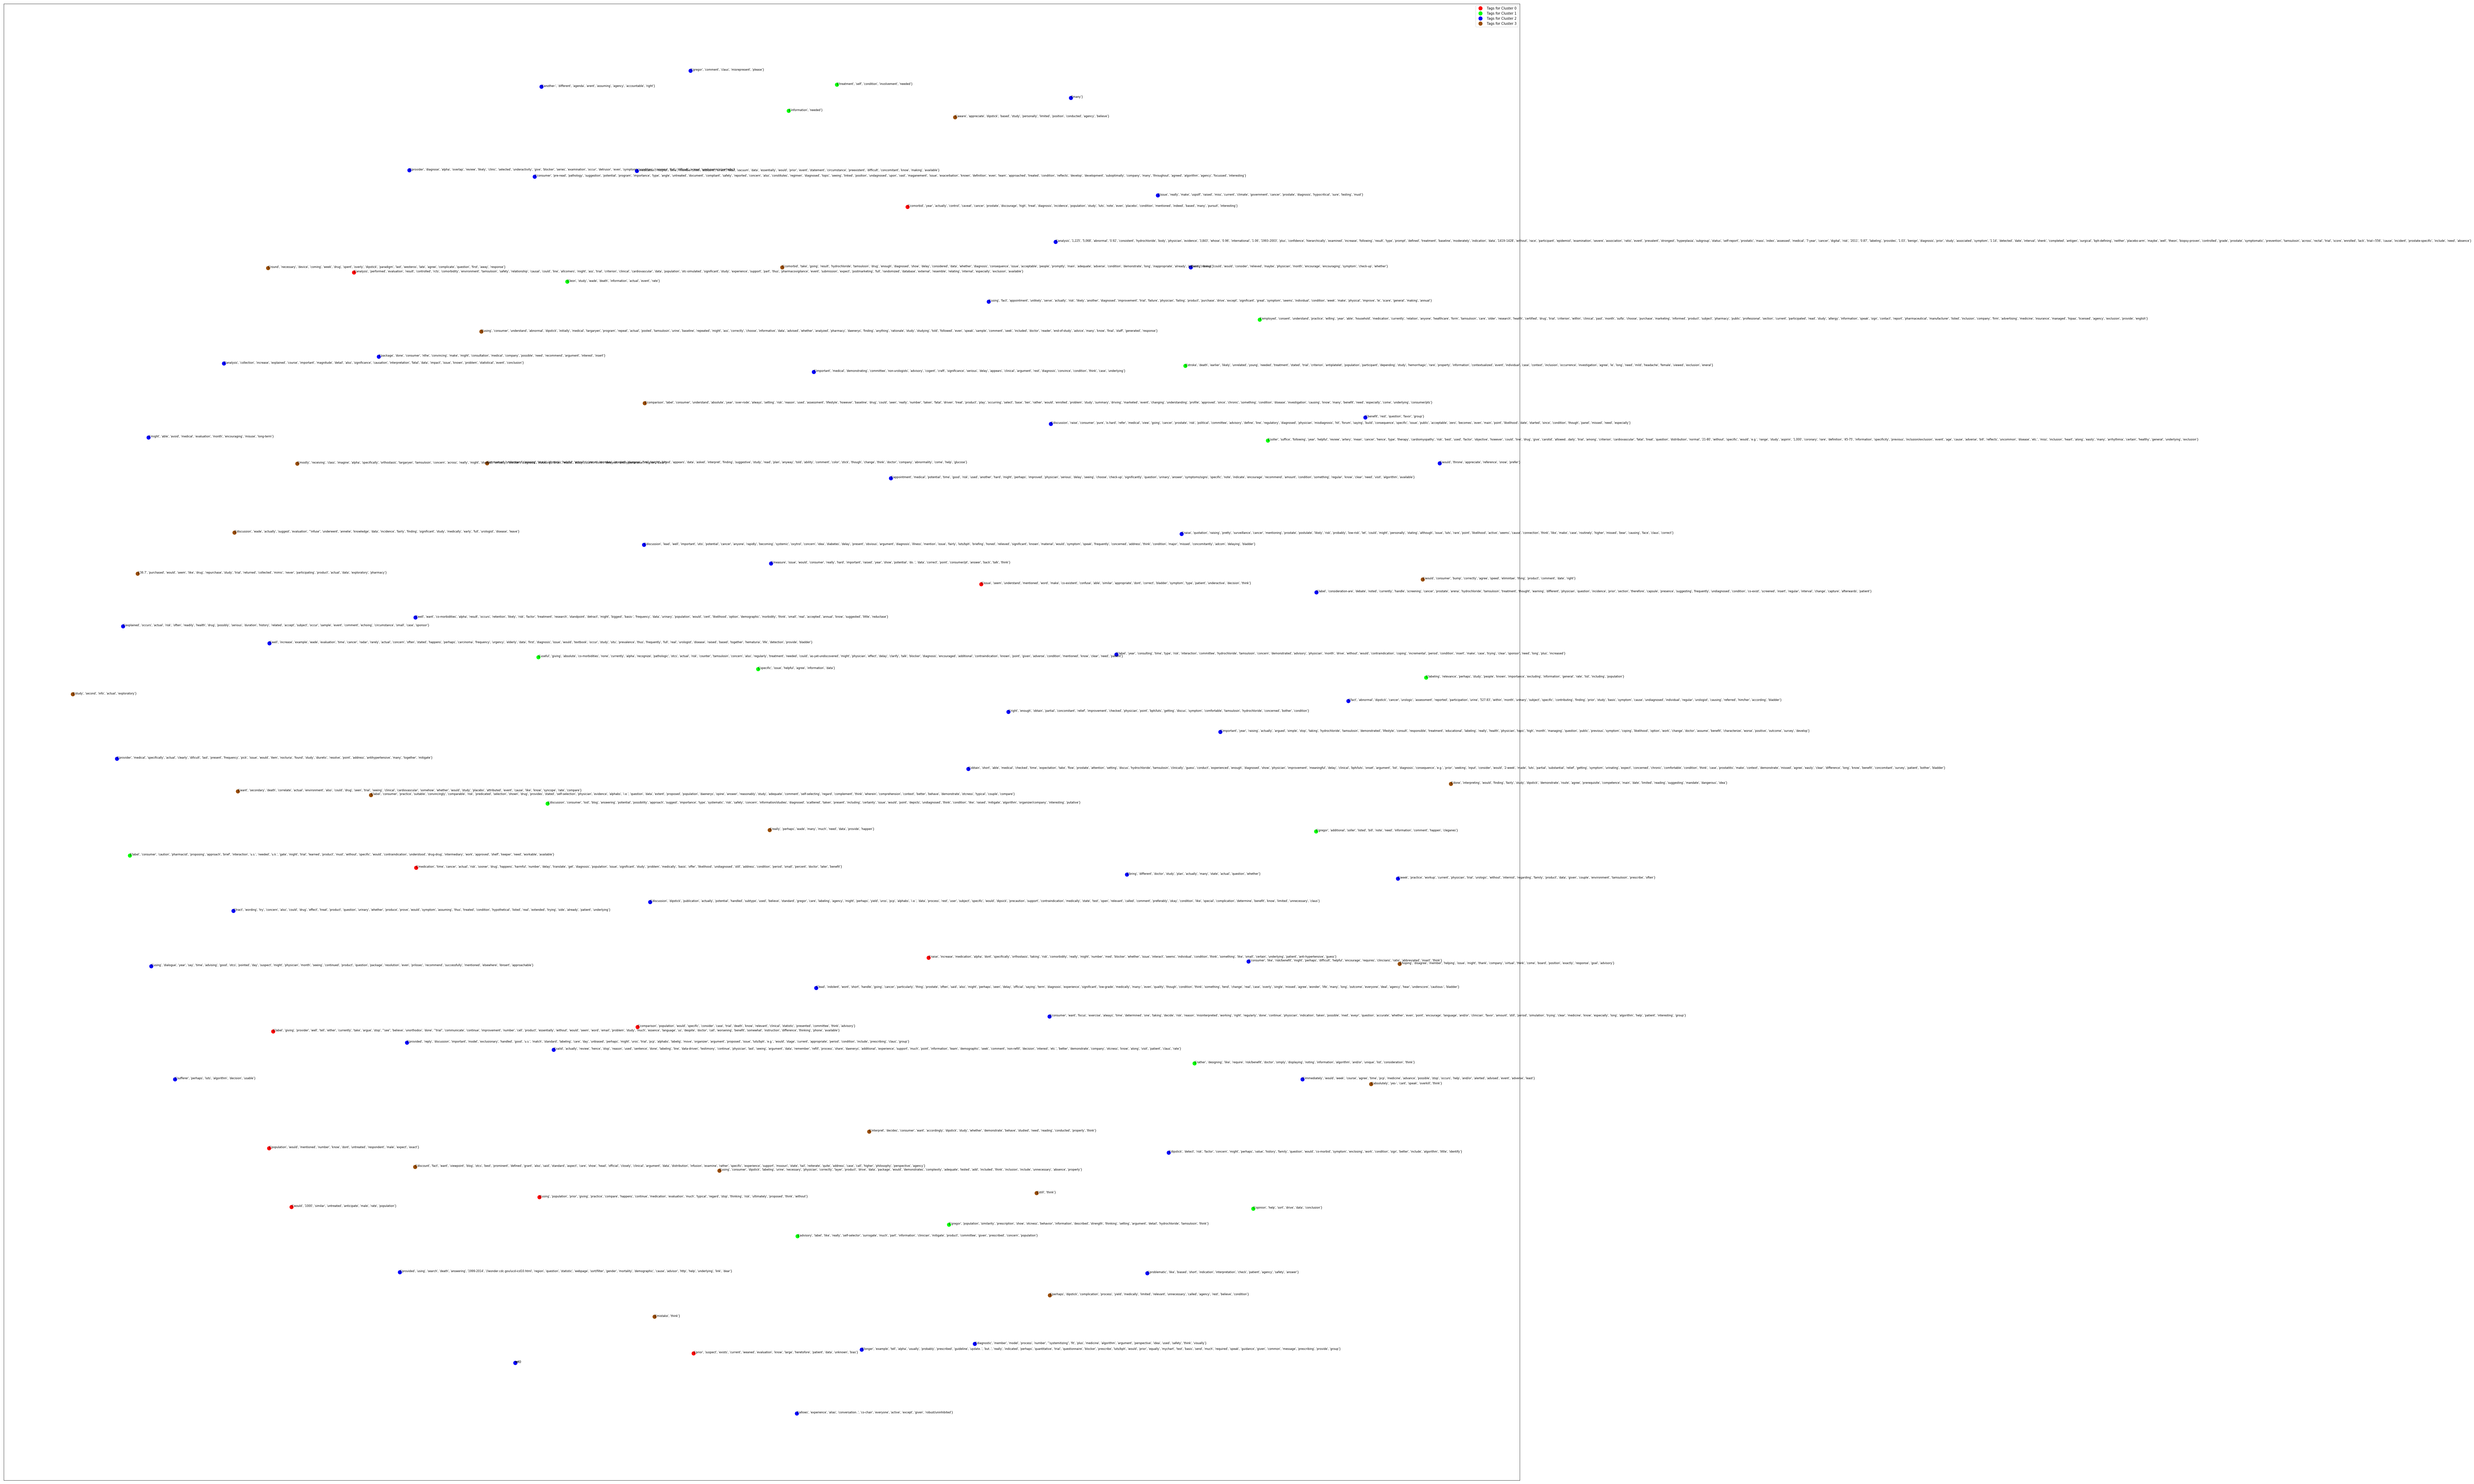

In [986]:
fig, ax = plt.subplots(figsize=(80, 80))
ax.margins(0.05)

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(xy_df)):
    ax.text(xy_df.loc[i]['x'], xy_df.loc[i]['y'], xy_df.loc[i]['lemmas'], size=8)  

    
    
plt.show() #show the plot

In [987]:
import mpld3

#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [988]:
#group by cluster
groups = xy_df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(30,30)) #set plot size
ax.margins(0.01) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.lemmas]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,voffset=10, hoffset=10, css=css)
    
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot


mpld3.display() #show the plot




#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

# Sentiment Analysis - TextBlob

In [989]:
from textblob import TextBlob

In [990]:
# Pattern Analyzer for Summary by Word Importance
first_sum_txtblob = TextBlob(str(first_sum))
sentences = (sent_tokenize(str(first_sum_txtblob)))
for sentence in sentences:
    txtblob = TextBlob(sentence)
    print("")
    print(sentence, txtblob.sentiment)
    
#Overall Sentiment for the Summmary
print("")
print("Overall Sentiment for Summary: ")
print(first_sum_txtblob.sentiment)


['i do think that the fda will raise the issue of missed prostate cancer again and while claus is correct in stating that we now routinely use active surveillance in low-risk men, one might postulate that the men with prostate cancer "causing" luts (cause in quotations because, lets face it, its pretty rare that cap causes luts although we like to make that connection) are more likely to have higher risk cancer. Sentiment(polarity=0.19444444444444442, subjectivity=0.75)

', 'this lack of association was consistent across subgroups defined by type of bph-defining event (treatment, symptoms, or physician diagnosis), prompt for prostate cancer diagnosis, and prostate cancer grade. Sentiment(polarity=0.25, subjectivity=0.25)

', 'as noted in the warning section of the rx insert: " screening for prostate cancer prostate cancer and bph frequently co-exist; therefore, patients should be screened for the presence of prostate cancer prior to treatment with tamsulosin hydrochloride capsules and

In [991]:
# Sentiment by Pattern Analysis. Summary of the summary.
second_sum_txtblob = TextBlob(str(second_sum))
sentences = sent_tokenize(str(second_sum_txtblob))
for sentence in sentences:
    txtblob = TextBlob(sentence)
    print("")
    print(sentence, txtblob.sentiment)

print("")
print("Overall Sentiment for the Summary of the Summary: ")
print(second_sum_txtblob.sentiment)


['\', \'as noted in the warning section of the rx insert: " screening for prostate cancer prostate cancer and bph frequently co-exist; therefore, patients should be screened for the presence of prostate cancer prior to treatment with tamsulosin hydrochloride capsules and at regular intervals afterwards". Sentiment(polarity=0.03333333333333333, subjectivity=0.12564102564102564)

', '\', "one occurrence of a very rare event in the population more likely to have the event in the eneral population may more likely be viewed as unrelated to the treatment (depending on the moa of the treatment), but two less so, and in any case any deaths in a trial needs individual investigation, contextualized by the inclusion and exclusion criteria for the trial.\\\\n\', \'when the details of the analysis are known, if the conclusion is an increase in fatal cv events of any magnitude that cannot be explained by data collection issues will be a problem. Sentiment(polarity=0.17476190476190476, subjectivity=

In [992]:
# Sentiment by Pattern Analysis. Summary of the summary.
second_sum_txtblob = TextBlob(str(summary_by_coll))
sentences = sent_tokenize(str(second_sum_txtblob))
for sentence in sentences:
    txtblob = TextBlob(sentence)
    print("")
    print(sentence, txtblob.sentiment)

print("")
print("Overall Sentiment for the Summary of the Summary: ")
print(second_sum_txtblob.sentiment)


['association of symptomatic benign prostatic hyperplasia and prostate cancer: results from the prostate cancer prevention trial. Sentiment(polarity=0.0, subjectivity=0.0)

', 'this study examined the association between symptomatic benign prostatic hyperplasia (bph) and prostate cancer risk in 5,068 placebo-arm participants enrolled in the prostate cancer prevention trial (1993–2003). Sentiment(polarity=0.0, subjectivity=0.0)

', 'bill soller\\n", \'inclusion criteria: 1. men, 18 years of age and older 2. able to speak, read and understand english. Sentiment(polarity=0.2222222222222222, subjectivity=0.3194444444444444)

', "bill soller\\n', 'everyone was given an alias except the active co-chair. Sentiment(polarity=-0.13333333333333333, subjectivity=0.6)

", 'i think fda will be concerned about those men who have a concomitant condition with bph/luts who obtain partial relief from tamsulosin hydrochloride, are comfortable enough with the improvement not to bother getting checked out,

In [993]:
# Sentiment Analysis of Summary by word collocations
# Pattern Analyzer
coll_txtblob = TextBlob(str(summary))
sentences = sent_tokenize(str(coll_txtblob))
for sentence in sentences:
    txtblob = TextBlob(sentence)
    print("")
    print(sentence, txtblob.sentiment)

print("")
print("Overall Sentiment for Summary by Word Collocations: ")
print(coll_txtblob.sentiment)


["shenk j et al association of symptomatic benign prostatic hyperplasia and prostate cancer: results from the prostate cancer prevention trial am j epidemiol 2011 jun 15; 173(12): 1419 1428 this study examined the association between symptomatic benign prostatic hyperplasia (bph) and prostate cancer risk in 5,068 placebo-arm participants enrolled in the prostate cancer prevention trial (1993 2003) these data include 1,225 men whose cancer was detected during the 7-year trial 556 detected for cause (following abnormal prostate-specific antigen or digital rectal examination) and 669 detected not for cause (without indication), as well as 3,843 men who had biopsy-proven absence of prostate cancer at the trial end symptomatic bph was assessed hierarchically as self-report of surgical or medical treatment, moderately severe symptoms (international prostate symptom score >14), or physician diagnosis, and analyses were completed by bph status at baseline (prevalent) or bph prior to cancer di

In [994]:
# Sentiment Analysis of Summary by word collocations
# Pattern Analyzer
coll_txtblob = TextBlob(str(cluster3))

print("")
print("Overall Sentiment for Summary by Word Collocations: ")
print(coll_txtblob.sentiment)


Overall Sentiment for Summary by Word Collocations: 
Sentiment(polarity=0.12156066781066775, subjectivity=0.45426842593509226)


In [995]:
scoreSentiment(cluster3, lexicon_dictionary)

('Positive', 37.263000000000005)

In [996]:
get_sent(str(summary_by_coll)) #TALLY OF SUMMARY BY COLLOCATIONS TEXTBLOB - 

# of sentences: 14
Positive Tally:
6
Negative Tally: 
1
Neutral Tally:
7


In [997]:
get_sent(str(file_input)) # SENTIMENT BY SENTENCES, TEXTBLOB, TALLY OF WEEK 1 -- ENTIRE DATASET.

# of sentences: 232
Positive Tally:
113
Negative Tally: 
32
Neutral Tally:
87


In [998]:
get_sent(str(first_sum_txtblob)) #SENTIMENT BY SENTENCES, TEXTBLOB, TALLY -- SUMMARY BY WORD IMPORTANCE

# of sentences: 5
Positive Tally:
5
Negative Tally: 
0
Neutral Tally:
0


In [999]:
get_sent(str(second_sum_txtblob)) # Sentiment of SUMMARY OF SUMMARY BY WORD IMPORTANCE

# of sentences: 14
Positive Tally:
6
Negative Tally: 
1
Neutral Tally:
7


In [1000]:
get_subj(str(second_sum_txtblob)) # SUBJECTIVITY OF SUMMARY OF SUMMARY BY WORD IMPORTANCE

# of sentences: 14
Subjectivity less than .20:
5
Subjectivity greater than .20, Less than .50: 
3
Subjectivity greater than .50:
5


In [1001]:
 get_subj(str(summary_by_coll)) #SUBJECTIVITY OF SUMMARY BY COLLOCATIONS

# of sentences: 14
Subjectivity less than .20:
5
Subjectivity greater than .20, Less than .50: 
3
Subjectivity greater than .50:
5


In [1002]:
get_subj(str(file_input)) #SUBJECTIVITY OF ENTIRE WEEK ONE.

# of sentences: 232
Subjectivity less than .20:
74
Subjectivity greater than .20, Less than .50: 
77
Subjectivity greater than .50:
64


In [1003]:
get_subj(str(first_sum_txtblob)) #SUBJECTIVITY OF SUMMARY BY WORD IMPORTANCE

# of sentences: 5
Subjectivity less than .20:
1
Subjectivity greater than .20, Less than .50: 
2
Subjectivity greater than .50:
2


# SentiWordNet Sentiment Analysis

In [1004]:
#Loading SentiWordNet
path = '/Users/shelinakhan/Desktop/Web_Data/RAP_Data/'


def loadSentiWordNet(lfile):
    lf = open(lfile)
    lines=lf.readlines()
    lf.close
    lexicon = {}
    for line in lines:
        info = line.split("\t")
        try:
            p_score = float(info[2])
            n_score = float(info[3]) * -1.0
            words = info[4].split(" ")
            for word in words:
                term = word.split("#")
                lexicon[term[0]]= p_score + n_score
        except:
            pass
    return lexicon

lexicon_dictionary = "SentiWordNet_3.0.0.txt"
lex_fileName=path+lexicon_dictionary
lexicon_dictionary = loadSentiWordNet(lex_fileName)

In [1005]:
#Overall Text Score
def scoreSentiment(text,lex_dic):
    score = 0.0
    keys = lexicon_dictionary.keys()
    tokens = apply_lemmatization(apply_stopwording(remove_punctuation(word_tokenize(str(text))),3))
    for token in tokens:
        if token in keys:
            score = score + lexicon_dictionary[token]
        sentiment = "Neutral"
        if score>0:
            sentiment = "Positive"
        if score<0:
            sentiment = "Negative"
    return sentiment, score

In [1006]:
# By Sentence Scores - Tallys
def scoreSentiment_sentences(text,lex_dic):
    pos_= []
    neg_=[]
    neu_=[]
    keys = lexicon_dictionary.keys()
    sentences = sent_tokenize(text)
    for sentence in sentences:
            tokens = apply_lemmatization(apply_stopwording(remove_punctuation(word_tokenize(str(sentence))),3))
            score = 0.0
            for token in tokens:
                if token in keys:
                    score = score + lexicon_dictionary[token]
            if score>0:
                pos_.append(sentence)
            if score<0:
                neg_.append(sentence)
            if score == 0:
                neg_.append(sentence)
                
    print("Number of Sentences: " + str(len(sentences)))
    print('Positive Tally: '+ str(len(pos_)))
    print('Negative Tally: ' + str(len(neg_)))
    print("Neutral Tally: " + str(len(neu_)))
   

# Overall Text Score - SentiWordNet

In [1007]:
scoreSentiment(file_input,lexicon_dictionary) # Sentiwordnet - Sentiment of entire corpus

('Positive', 58.569)

In [1008]:
scoreSentiment(first_sum_txtblob, lexicon_dictionary) #Sentiwordnet - sentiment of summary by word importance.

('Negative', -1.875)

In [1009]:
scoreSentiment(summary_by_coll, lexicon_dictionary) #sentiwordnet - sentiment of summary by word collocations

('Positive', 4.125)

In [1010]:
scoreSentiment(second_sum_txtblob, lexicon_dictionary) #sentiwordnet - sentiment of summary of summer - word importance.

('Positive', 4.125)

In [1011]:
scoreSentiment(cluster1_,lexicon_dictionary)

('Positive', 18.887999999999998)

In [1012]:
scoreSentiment(cluster2,lexicon_dictionary)

('Positive', 38.0)

In [1013]:
scoreSentiment(cluster3,lexicon_dictionary)

('Positive', 37.263000000000005)

# SentiWordNet - Sentence Tallys

In [1014]:
scoreSentiment_sentences(str(file_input), lexicon_dictionary) # Sentiment Tallys - Entire Corpus

Number of Sentences: 232
Positive Tally: 137
Negative Tally: 95
Neutral Tally: 0


In [1015]:
scoreSentiment_sentences(str(first_sum_txtblob), lexicon_dictionary) #Sentiment Tallys - Summary by word importance

Number of Sentences: 5
Positive Tally: 2
Negative Tally: 3
Neutral Tally: 0


In [1016]:
scoreSentiment_sentences(str(second_sum_txtblob), lexicon_dictionary) #Sentiment tallys - summary of summary of word importance.

Number of Sentences: 14
Positive Tally: 8
Negative Tally: 6
Neutral Tally: 0


In [1017]:
scoreSentiment_sentences(str(summary_by_coll), lexicon_dictionary) # sentiment by summary by collocations

Number of Sentences: 14
Positive Tally: 8
Negative Tally: 6
Neutral Tally: 0


In [1018]:
scoreSentiment_sentences(cluster1_,lexicon_dictionary) #cluster 1 - sentiment sentiwordnet

Number of Sentences: 103
Positive Tally: 55
Negative Tally: 48
Neutral Tally: 0


In [1019]:
scoreSentiment_sentences(cluster2,lexicon_dictionary) #cluster2 - sentiwordnet

Number of Sentences: 178
Positive Tally: 97
Negative Tally: 81
Neutral Tally: 0


In [1020]:
scoreSentiment_sentences(cluster3,lexicon_dictionary) #cluster 3 - sentiwordnet

Number of Sentences: 181
Positive Tally: 104
Negative Tally: 77
Neutral Tally: 0


In [1021]:
scoreSentiment(str(summary_by_coll),lexicon_dictionary) #cluster 3 - sentiwordnet

('Positive', 4.125)